In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import math_optimization_library as optlib

from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import superlearn_library as superlib
classif_plotter = nonlib.nonlinear_classification_demos

datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

static_plotter = optlib.static_plotter.Visualizer()
regress_plotter = nonlib.nonlinear_regression_demos
classif_history_plotter = superlib.classification_static_plotter

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

Below we provide a short implementation of this pseduo-code in Python.

In [3]:
def create_stumps(x,y):
    '''
    Create stumps tailored to an input dataset (x,y) based on the naive method of creating
    a split point between each pair of successive inputs.  
    
    The input to this function: a dataset (x,y) where the input x has shape 
    (NUMBER OF POINTS by  DIMENSION OF INPUT)
    
    The output of this function is a set of two lists, one containing the split points and 
    the other the corresponding levels of stumps.
    '''
    
    # containers for the split points and levels of our stumps, along with container
    # for which dimension the stump is defined along
    splits = []
    levels = []
    dims = []
    
    # important constants: dimension of input N and total number of points P
    N = np.shape(x)[0]              
    P = np.size(y)

    ### begin outer loop - loop over each dimension of the input
    for n in range(N):
        # make a copy of the n^th dimension of the input data (we will sort after this)
        x_n = copy.deepcopy(x[n,:])
        y_n = copy.deepcopy(y)
        
        # sort x_n and y_n according to ascending order in x_n
        sorted_inds = np.argsort(x_n,axis = 0)
        x_n = x_n[sorted_inds]
        y_n = y_n[:,sorted_inds]
        for p in range(P - 1):
            # compute and store split point
            split = (x_n[p] + x_n[p+1])/float(2)
            splits.append(split)

            # gather output points to left and right of split
            output_left  = y_n[:,:p+1] 
            output_right = y_n[:,p+1:]

            # compute average on each side, assign to levels
            ave_left = np.mean(output_left)
            ave_right = np.mean(output_right)
            levels.append([ave_left,ave_right])

            # remember the dimension this stump is defined along
            dims.append(n)
                
    # return items
    return splits,levels,dims

# 2. Generic boosting

#### <span style="color:#a50e3e;">Example 1. </span>   Fitting all stumps to a dataset simultaneously leads to severe overfitting

<IPython.core.display.Javascript object>


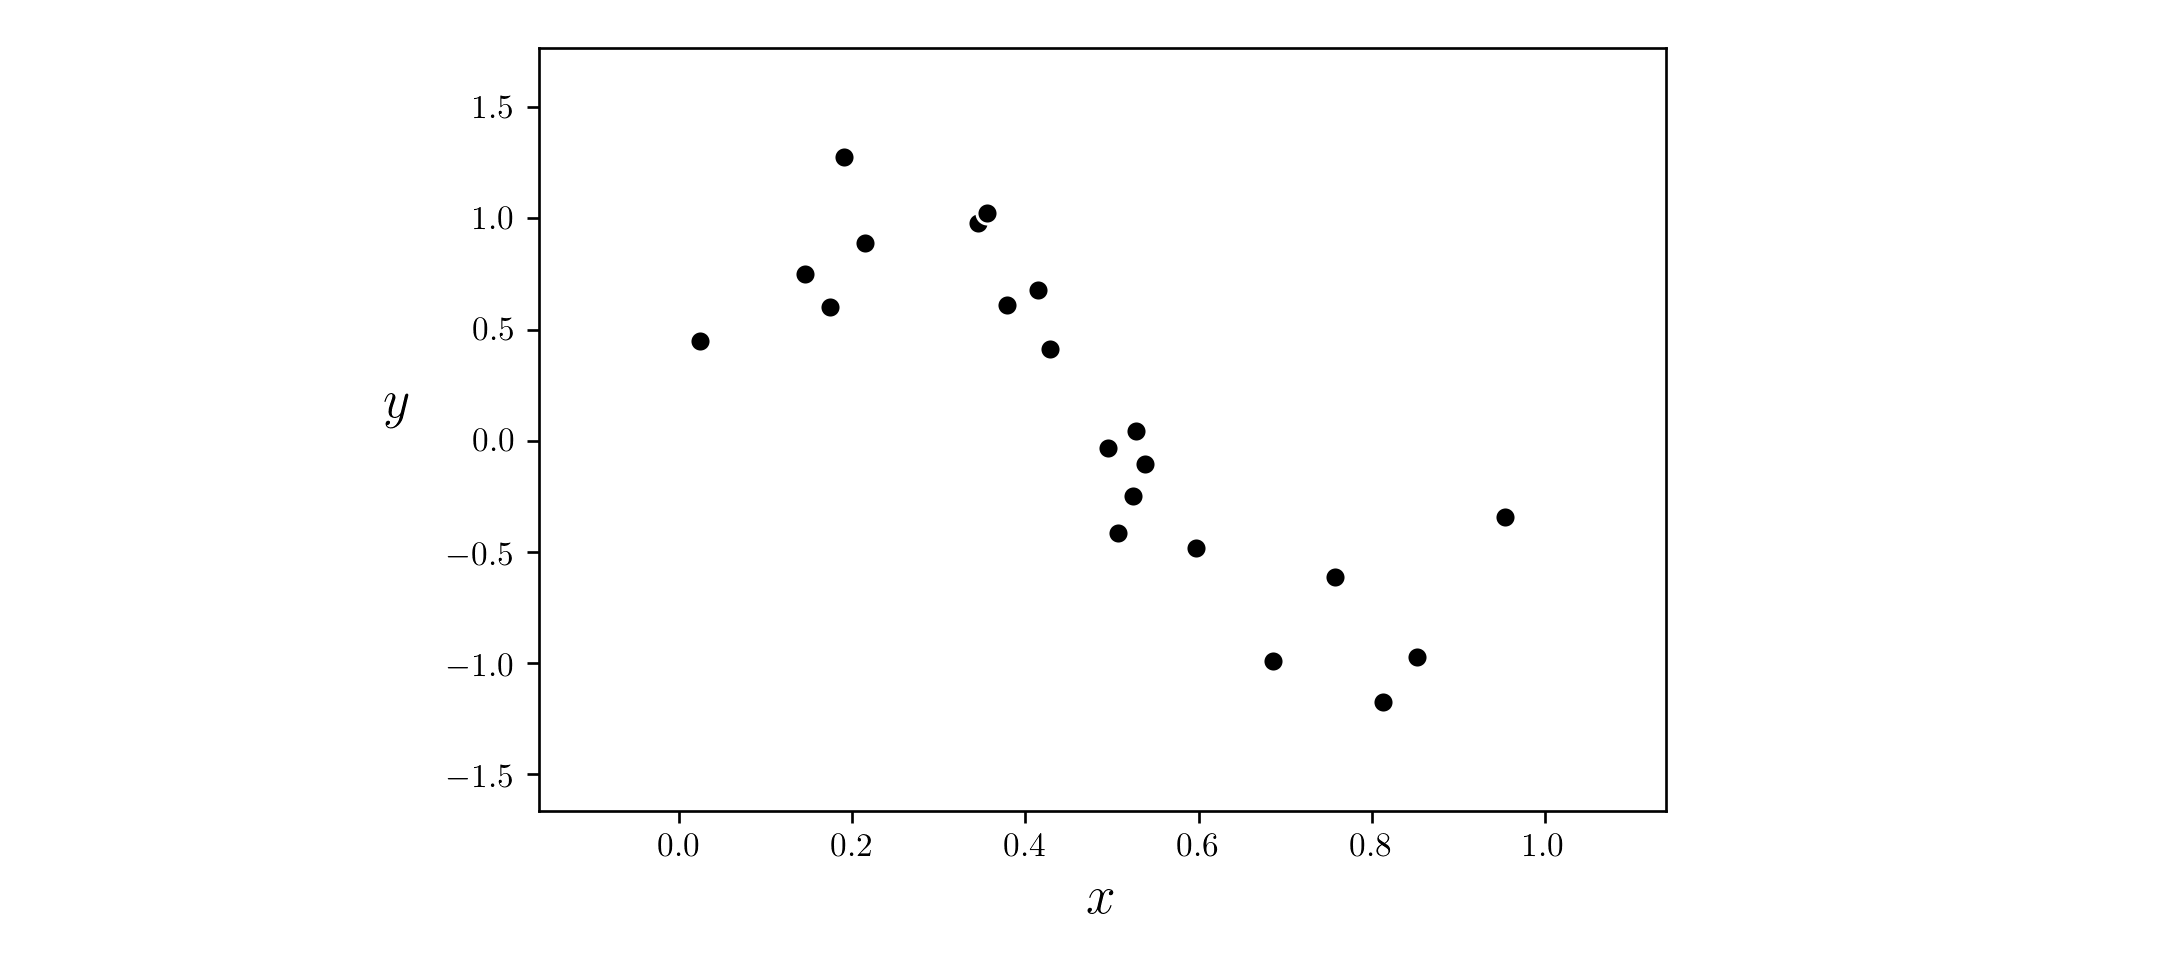

In [53]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

We first generate the set of stumps for this dataset - this is the same set shown in the first animation of the previous Section.  We use the ``make_stumps`` function defined previously to do this.

In [82]:
# create stumps for this dataset
splits,levels,dims = create_stumps(x,y)

With our stumps defined in terms of their ``splits`` and ``levels`` we can now construct a ``predict`` function in Python, as well as a ``least_squares`` function.  We do this below.

In [118]:
# compute transformation on entire set of inputs
def feature_transforms(x): 
    # container for stump transformed data
    x_transformed = np.zeros((len(splits),x.shape[1]))
    
    # loop over points and transform each individually
    for pt in range(x.shape[1]):
        x_n = x[:,pt]
    
        # loop over the stump collectionand calculate weighted contribution
        for u in range(len(splits)):
            # get current stump f_u
            split = splits[u]
            level = levels[u]

            ### our stump function f_u(x)
            if x_n <= split:  # lies to the left - so evaluate at left level
                x_transformed[u][pt] = level[0]
            else:
                x_transformed[u][pt]  = level[1]
    return x_transformed

Since the prediction function here has no internal parameters that need tuning, the Least Squares cost function can be minimized via e.g., gradient descent.  We do this in the next Python cell.

<IPython.core.display.Javascript object>


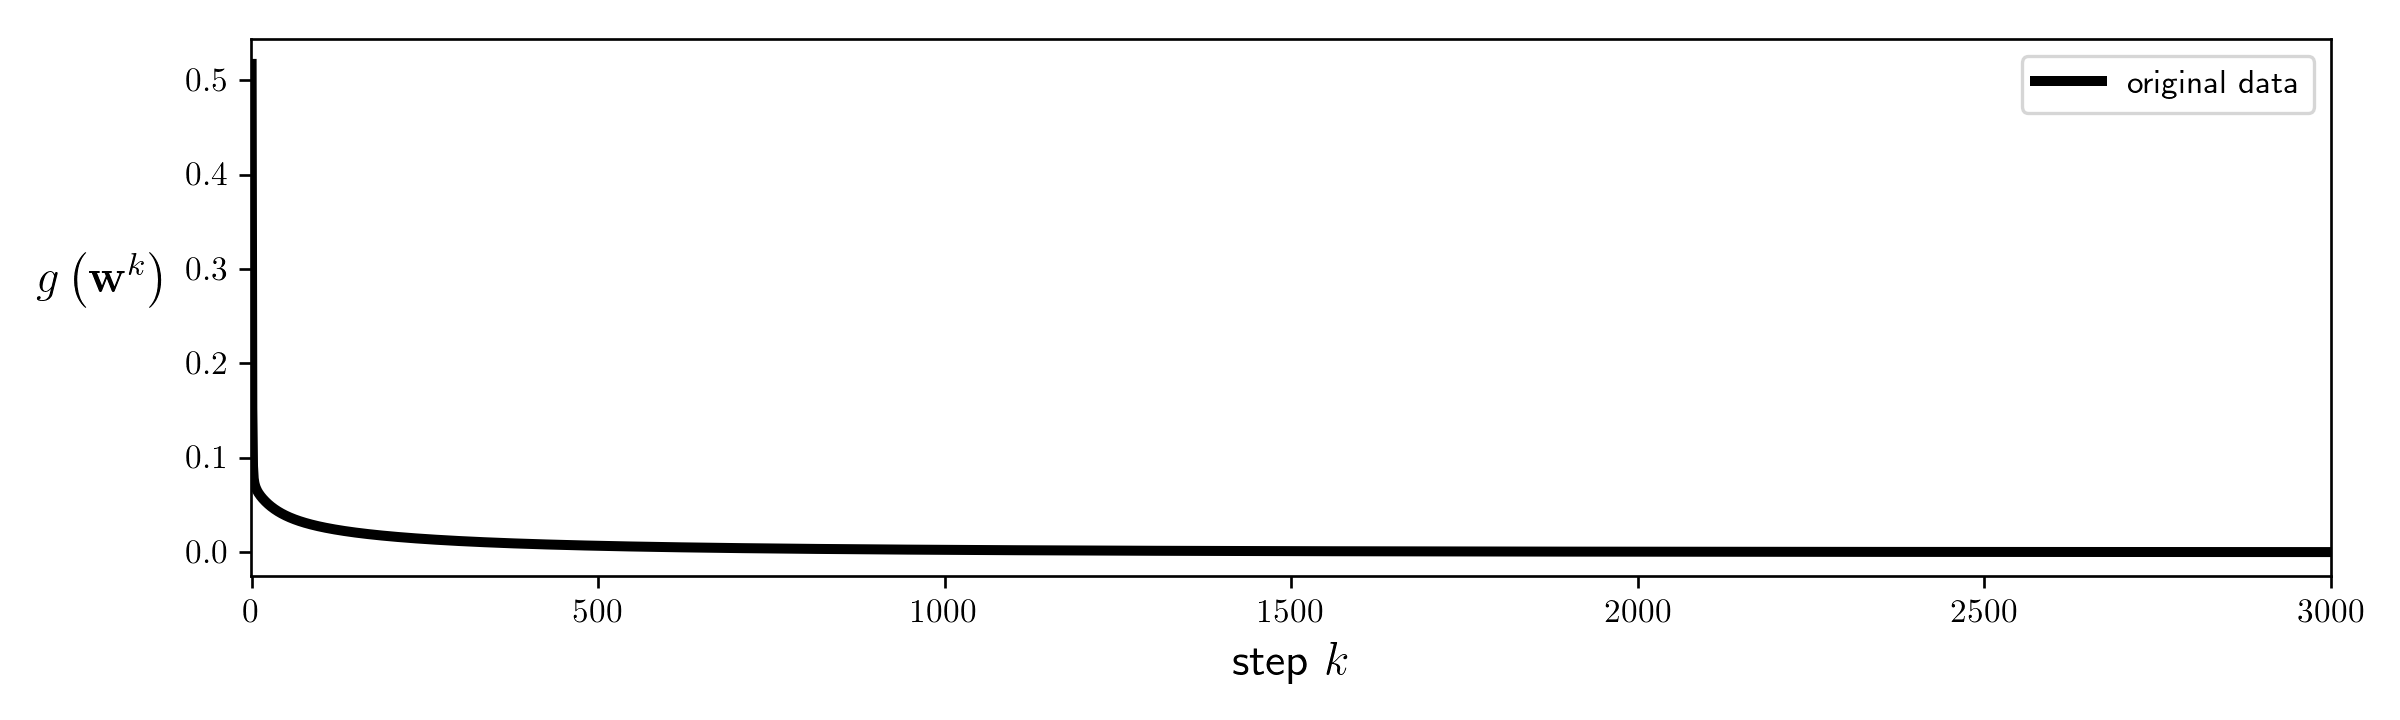

In [130]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 3000; alpha_choice = 10**(-1)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([run.cost_history],start = 0,points = False,labels = ['original data'])

With our weights tuned we can plot the resulting model - which overfits our dataset!

<IPython.core.display.Javascript object>


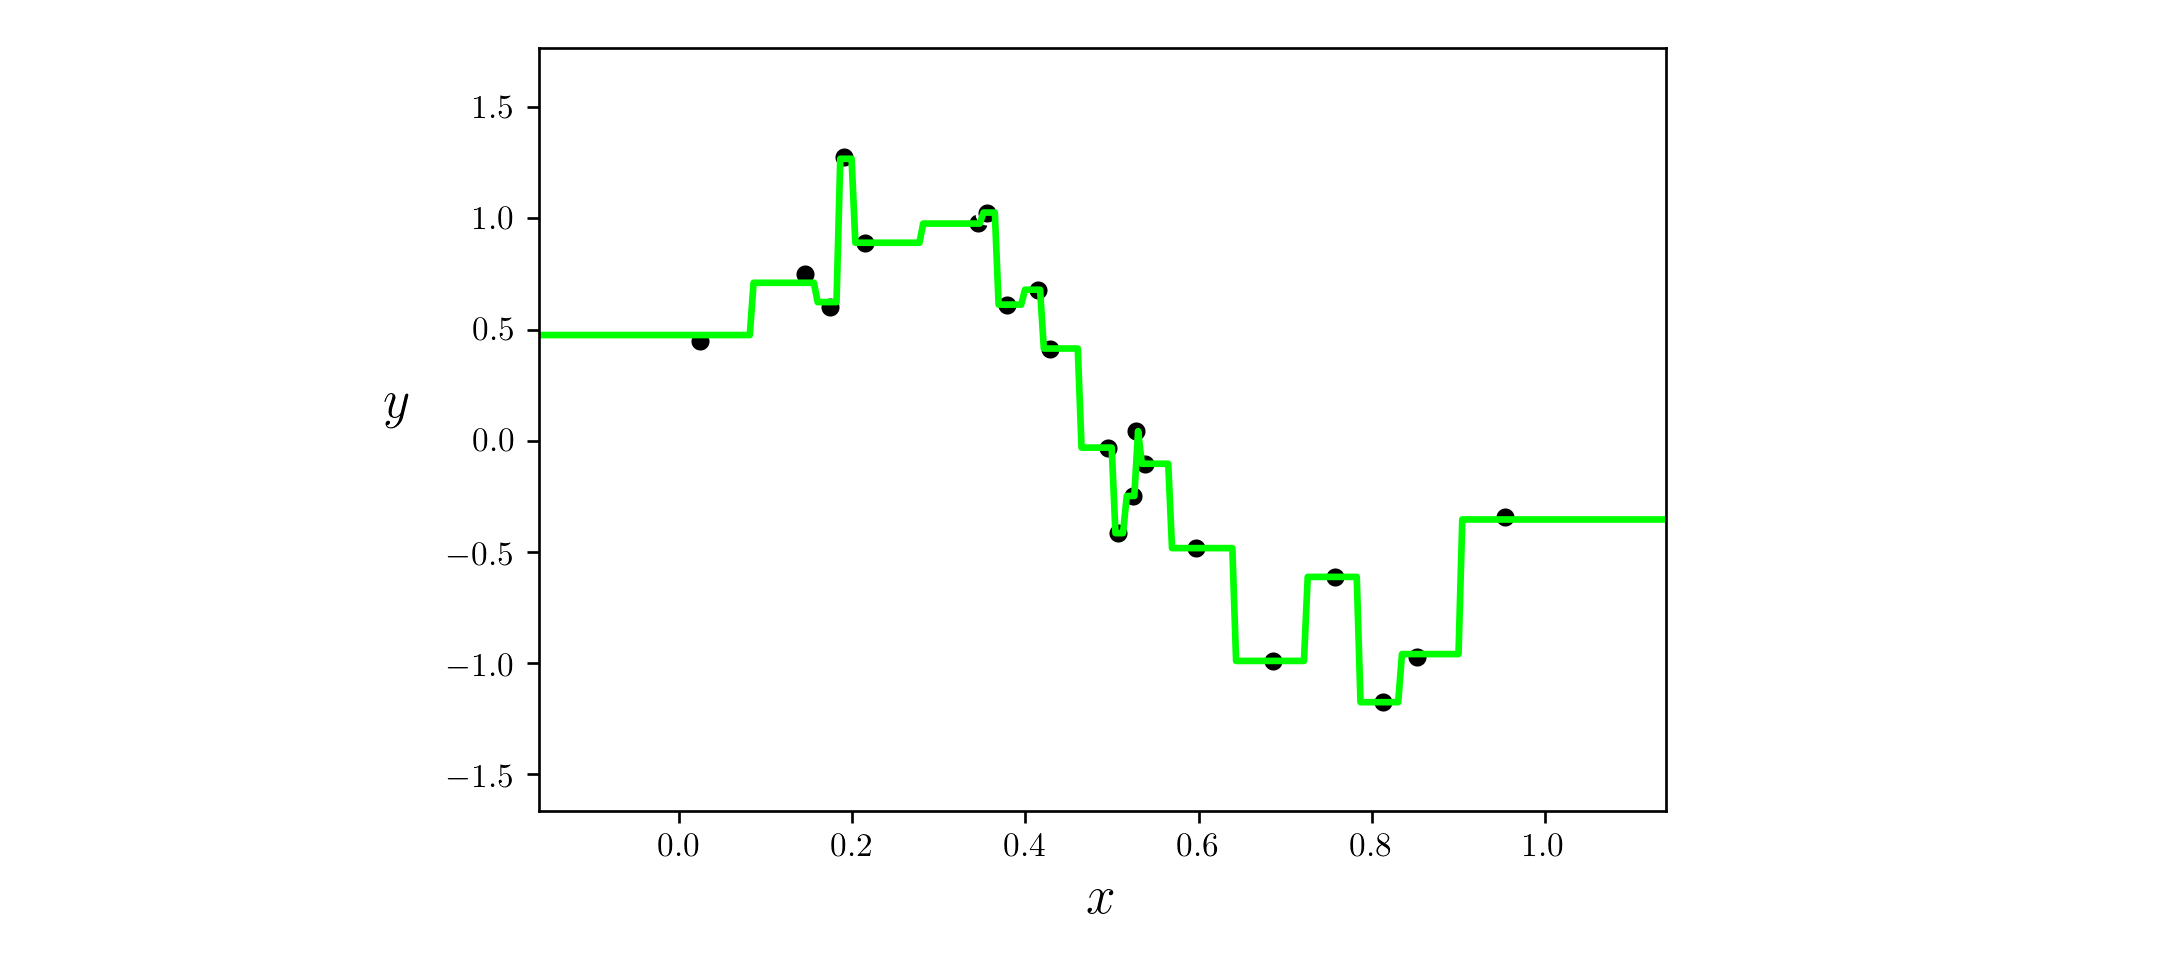

In [132]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

# Gradient boosting via descent

Now we do two stumps per split - one binary (1) on one side, one binary (1) on the other.

In [4]:
def create_boost_stumps(x,y):
    '''
    Create stumps tailored to an input dataset (x,y) based on the naive method of creating
    a split point between each pair of successive inputs.  
    
    The input to this function: a dataset (x,y) where the input x has shape 
    (NUMBER OF POINTS by  DIMENSION OF INPUT)
    
    The output of this function is a set of two lists, one containing the split points and 
    the other the corresponding levels of stumps.
    '''
    
    # containers for the split points and levels of our stumps, along with container
    # for which dimension the stump is defined along
    splits = []
    levels = []
    dims = []
    
    # important constants: dimension of input N and total number of points P
    N = np.shape(x)[0]              
    P = np.size(y)

    ### begin outer loop - loop over each dimension of the input
    for n in range(N):
        # make a copy of the n^th dimension of the input data (we will sort after this)
        x_n = copy.deepcopy(x[n,:])
        y_n = copy.deepcopy(y)
        
        # sort x_n and y_n according to ascending order in x_n
        sorted_inds = np.argsort(x_n,axis = 0)
        x_n = x_n[sorted_inds]
        y_n = y_n[:,sorted_inds]
        
        # loop over points and create stump in between each 
        # in dimension n
        for p in range(P - 1):
            # compute split point
            split = (x_n[p] + x_n[p+1])/float(2)
            
            ### create non-zero stump to 'left' of split ###
            # compute and store split point
            splits.append(split)
            levels.append([1,0])
            dims.append(n)
            
            ### create non-zero stump to 'right' of split ###
            # compute and store split point
            splits.append(split)
            levels.append([0,1])
            dims.append(n)
                
    # return items
    return splits,levels,dims

<IPython.core.display.Javascript object>


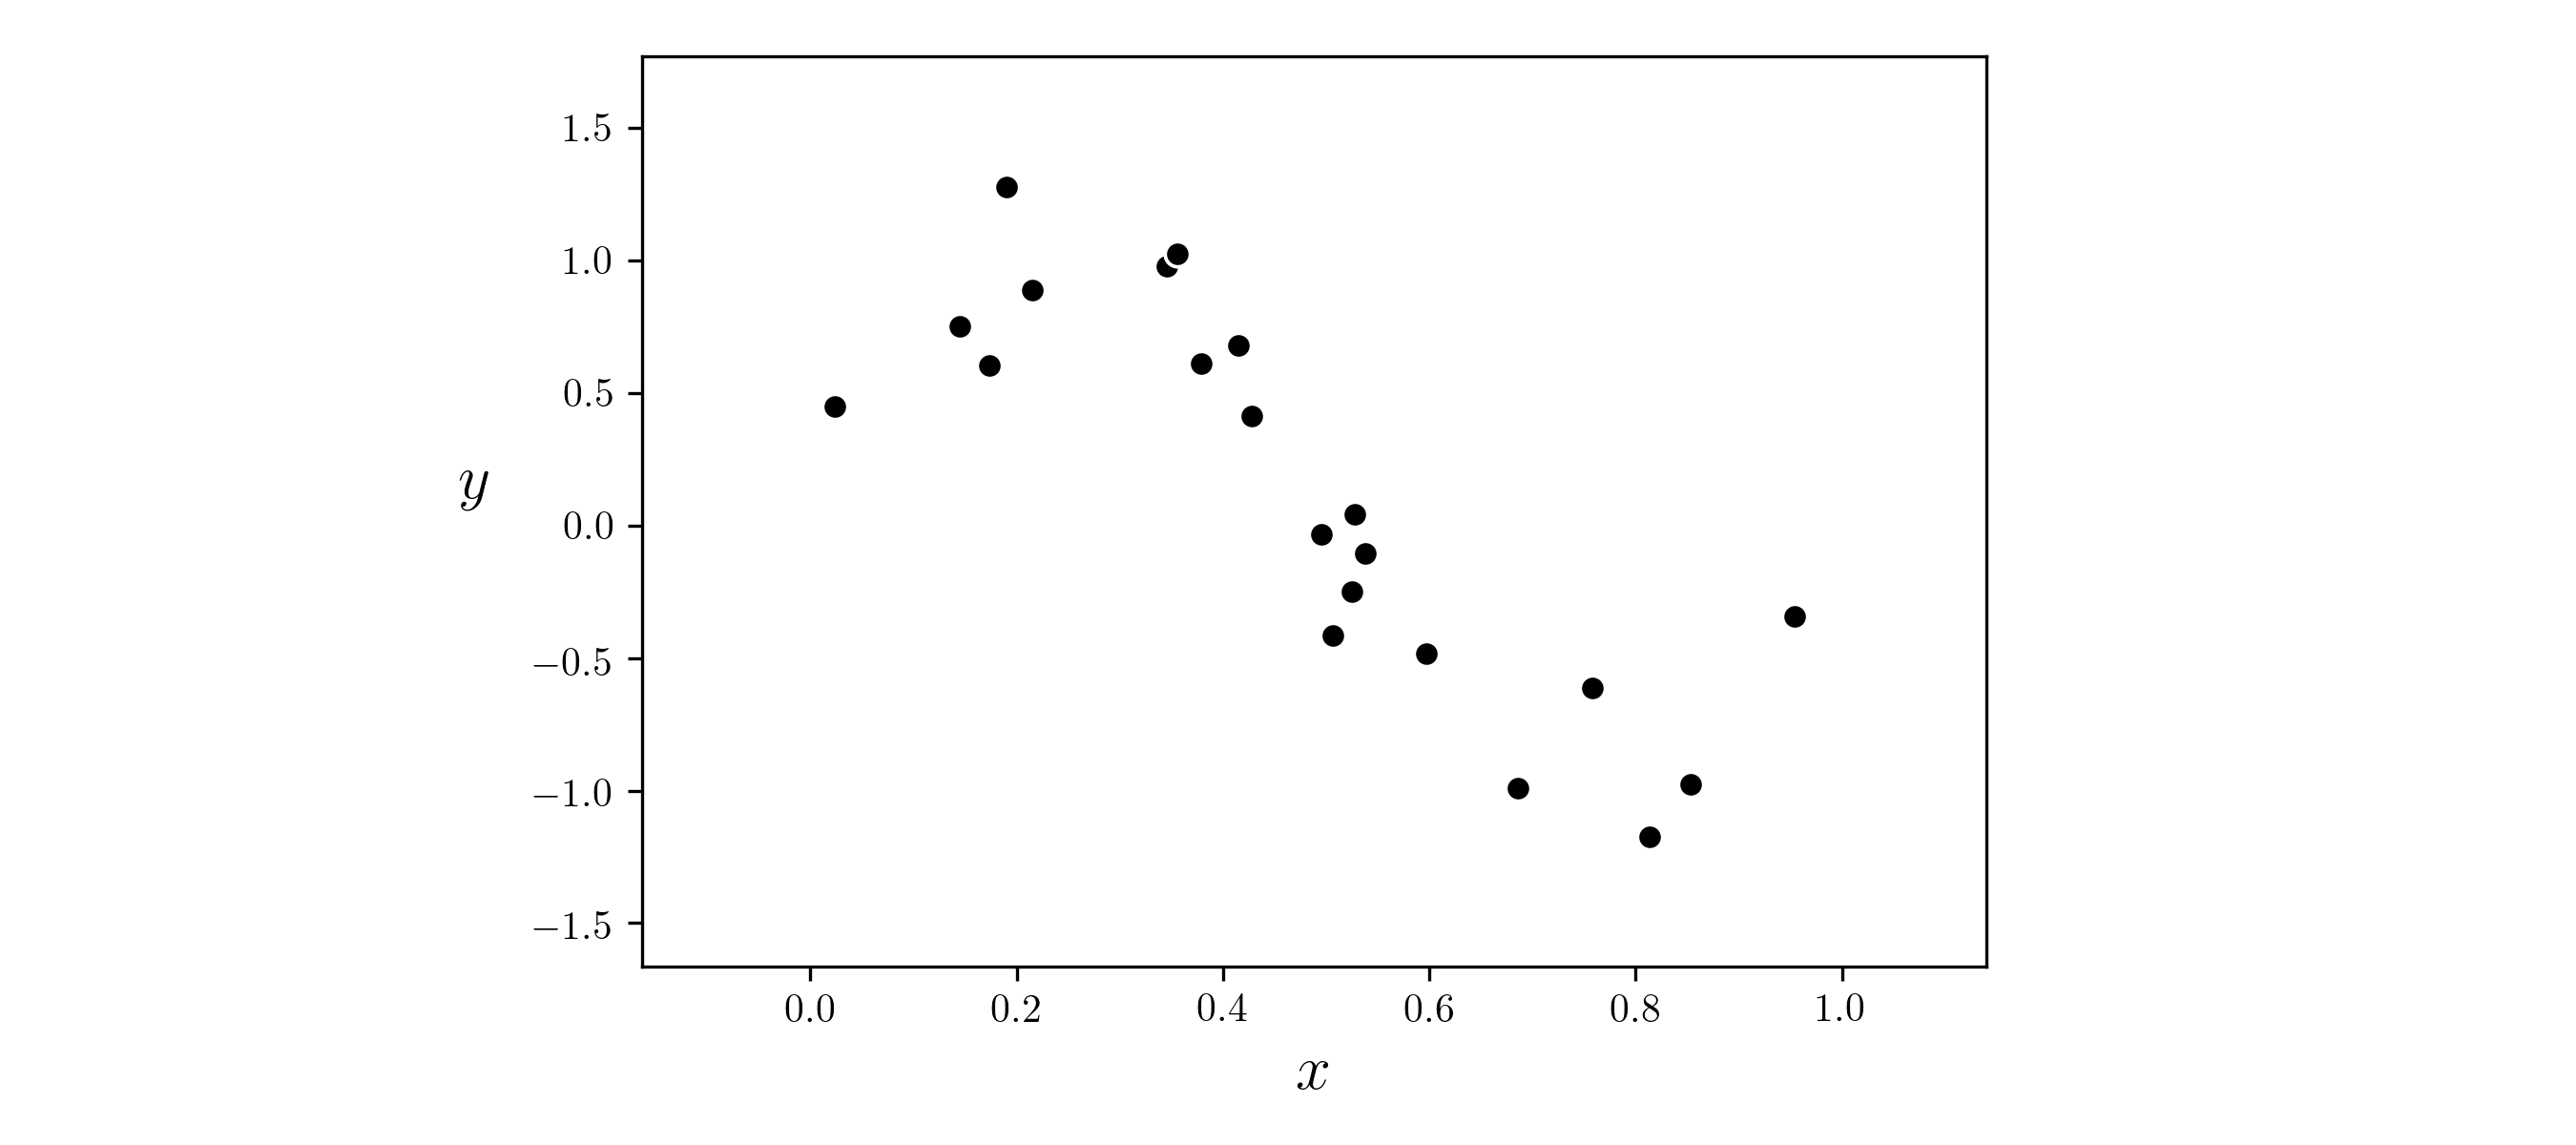

In [4]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

In [10]:
# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

In [14]:
# compute transformation on entire set of inputs
def feature_transforms(x): 
    # container for stump transformed data
    x_transformed = np.zeros((len(splits),x.shape[1]))
    
    # loop over points and transform each individually
    for pt in range(x.shape[1]):
        x_n = x[:,pt]
    
        # loop over the stump collectionand calculate weighted contribution
        for u in range(len(splits)):
            # get current stump f_u
            split = splits[u]
            level = levels[u]

            ### our stump function f_u(x)
            if x_n <= split:  # lies to the left - so evaluate at left level
                x_transformed[u][pt] = level[0]
            else:
                x_transformed[u][pt]  = level[1]
    return x_transformed

In [51]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 1; alpha_choice = 10**(-2)
w = 0.1*np.random.randn(len(splits)+1,1);

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its,algo = 'newtons_method')

<IPython.core.display.Javascript object>


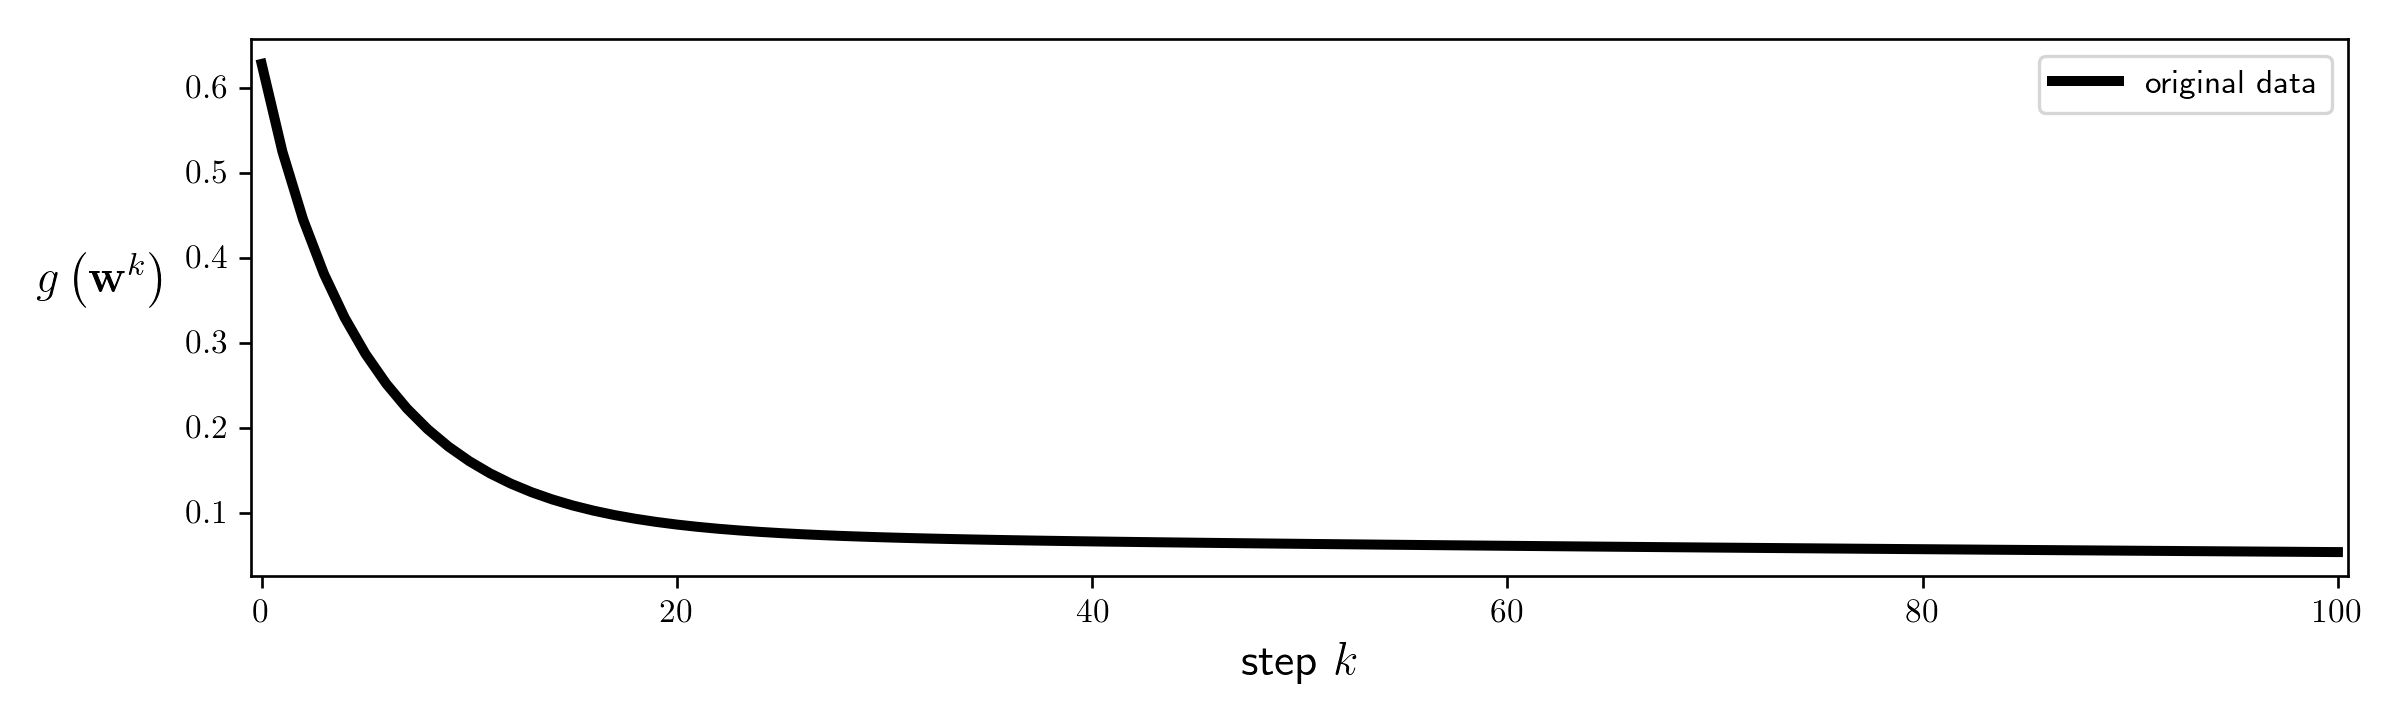

In [47]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run.cost_history],start = 0,points = False,labels = ['original data'])

<IPython.core.display.Javascript object>


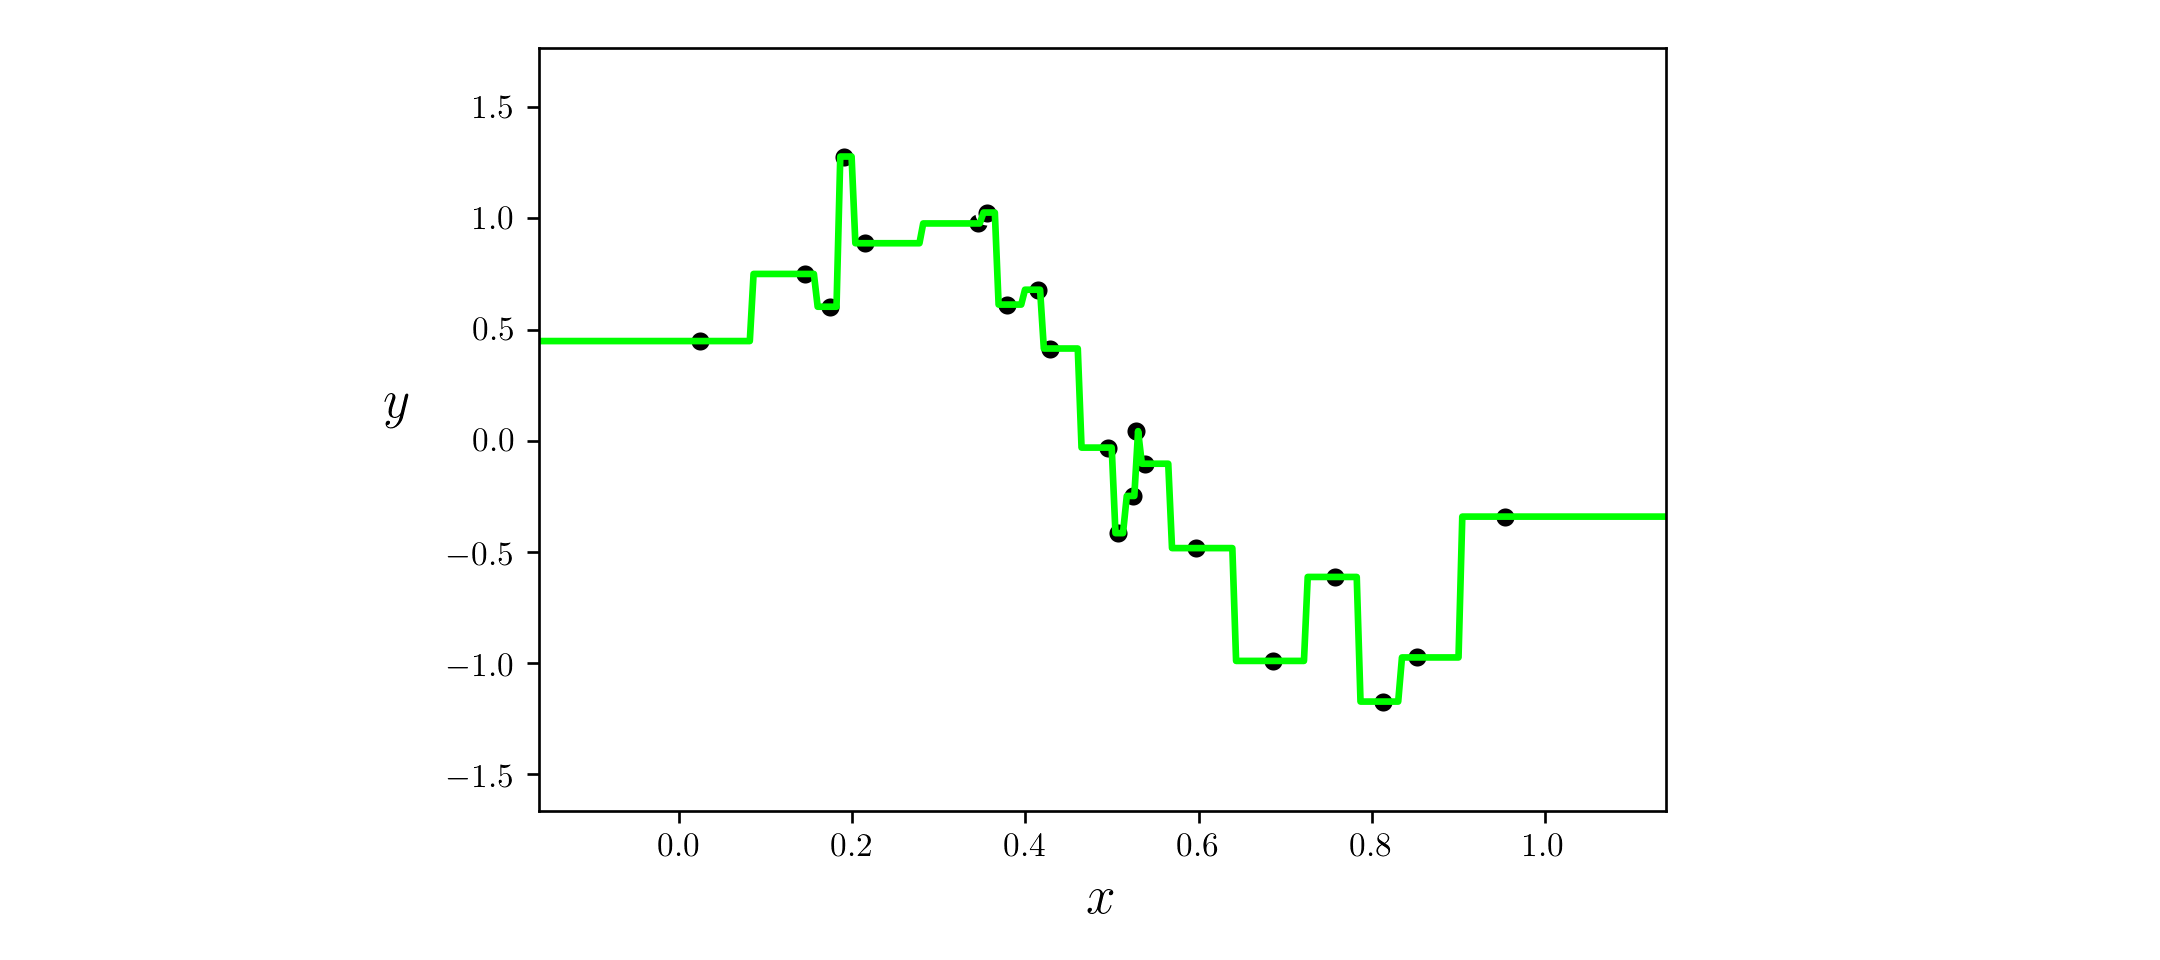

In [52]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

# two class classification - one dimensional

<IPython.core.display.Javascript object>


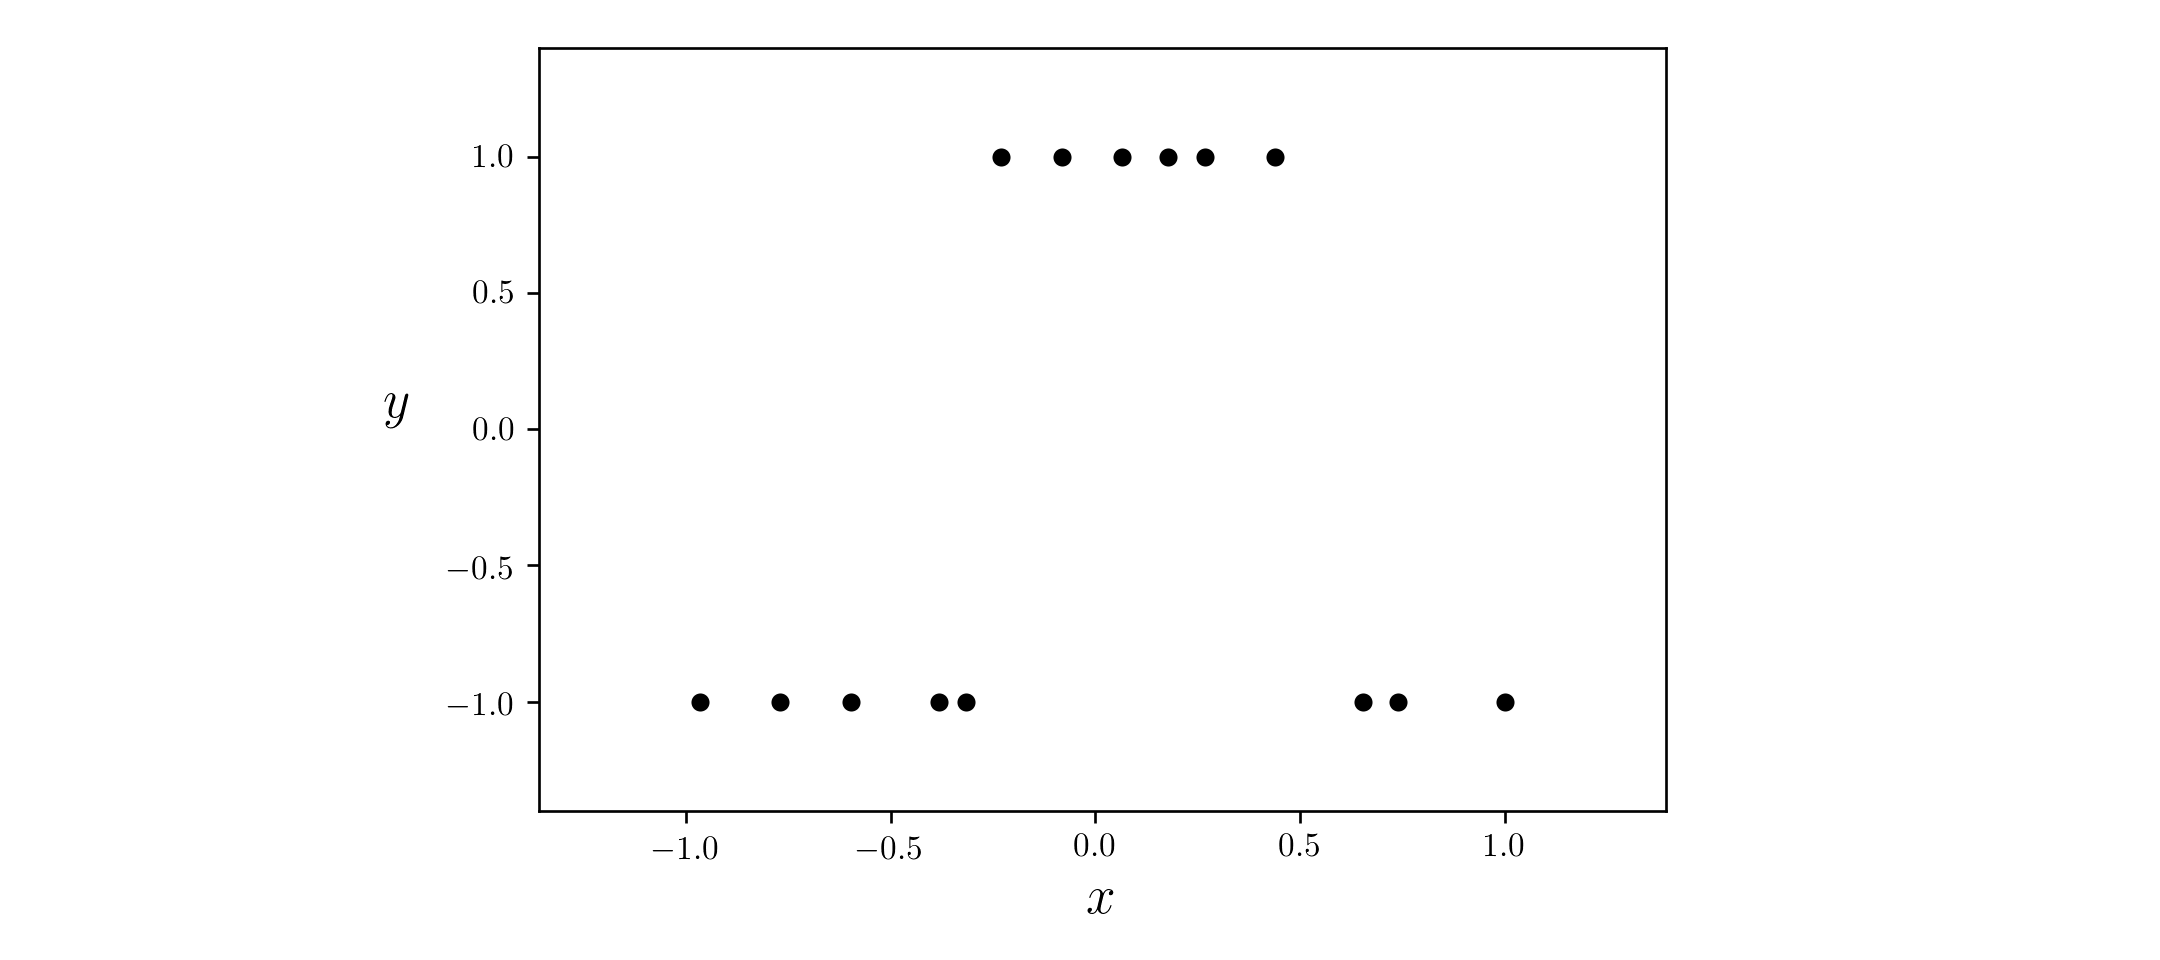

In [71]:
# load data
csvname = datapath + 'signed_projectile.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load in input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = classif_plotter.Visualizer(data)
demo.plot_data()

In [61]:
# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

In [65]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 10; alpha_choice = 10**(-2)
w = 0.1*np.random.randn(len(splits)+1,1);

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its,algo = 'newtons_method')
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


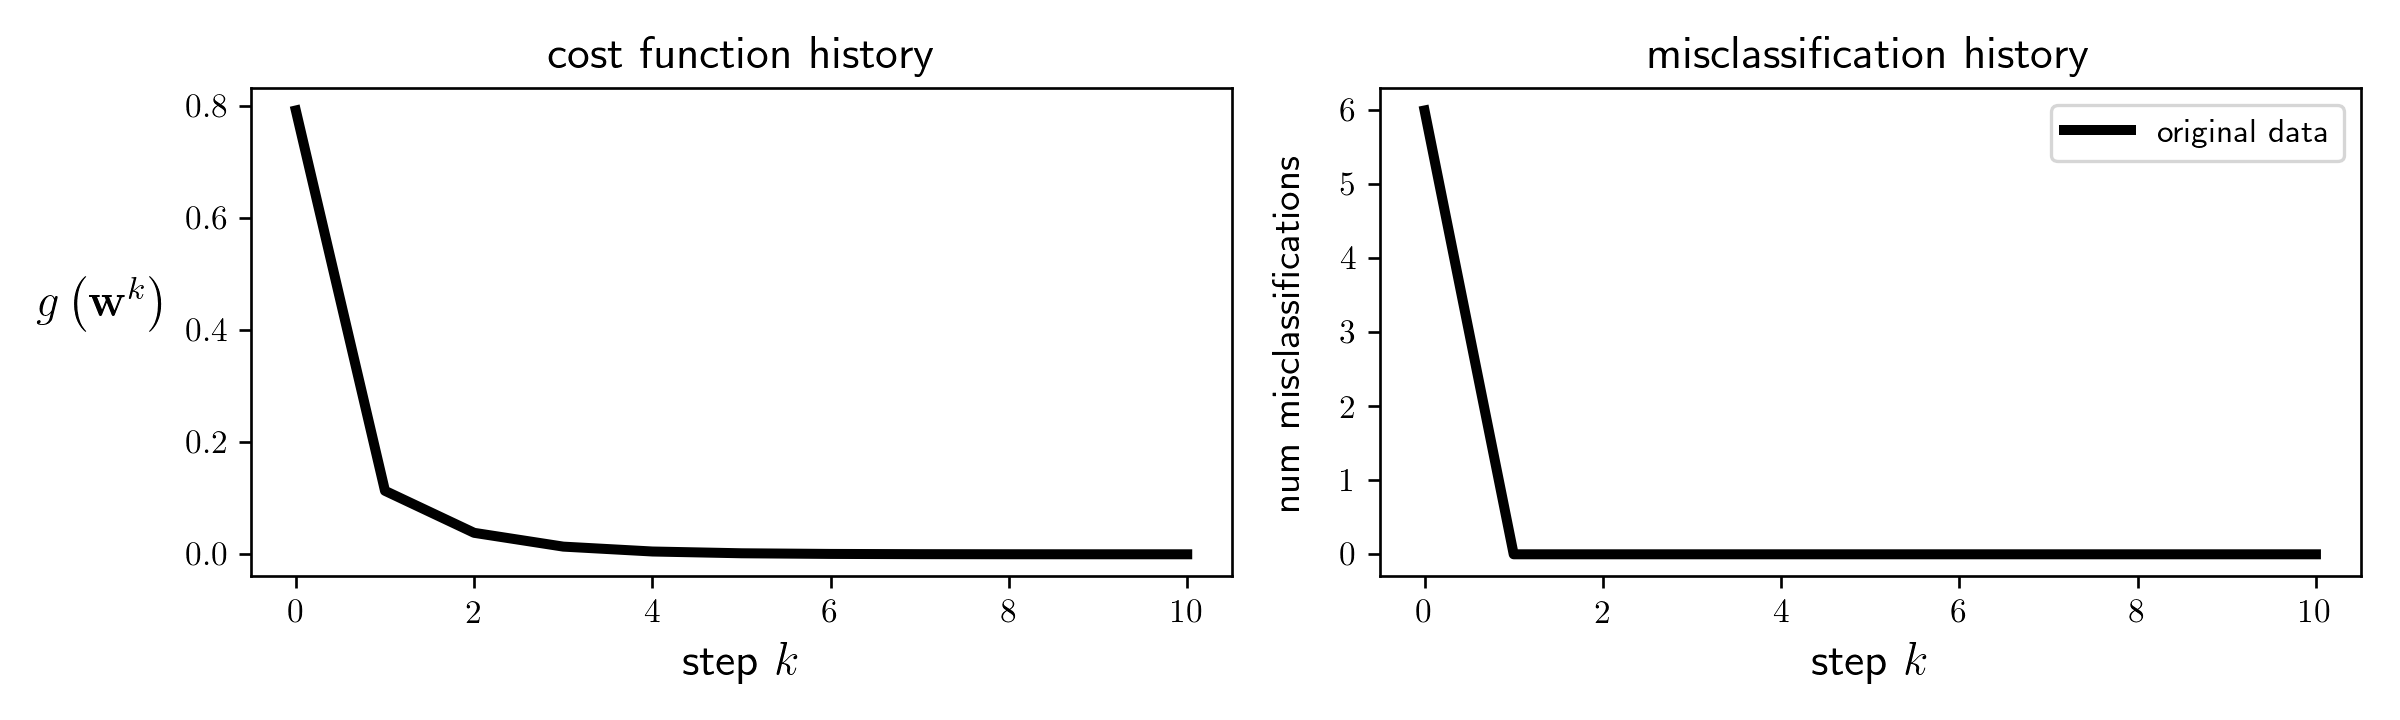

In [68]:
plotter = classif_history_plotter.Visualizer()
plotter.plot_cost_histories([run.cost_history],[count_history],start = 0,points = False,labels = ['original data'])

<IPython.core.display.Javascript object>


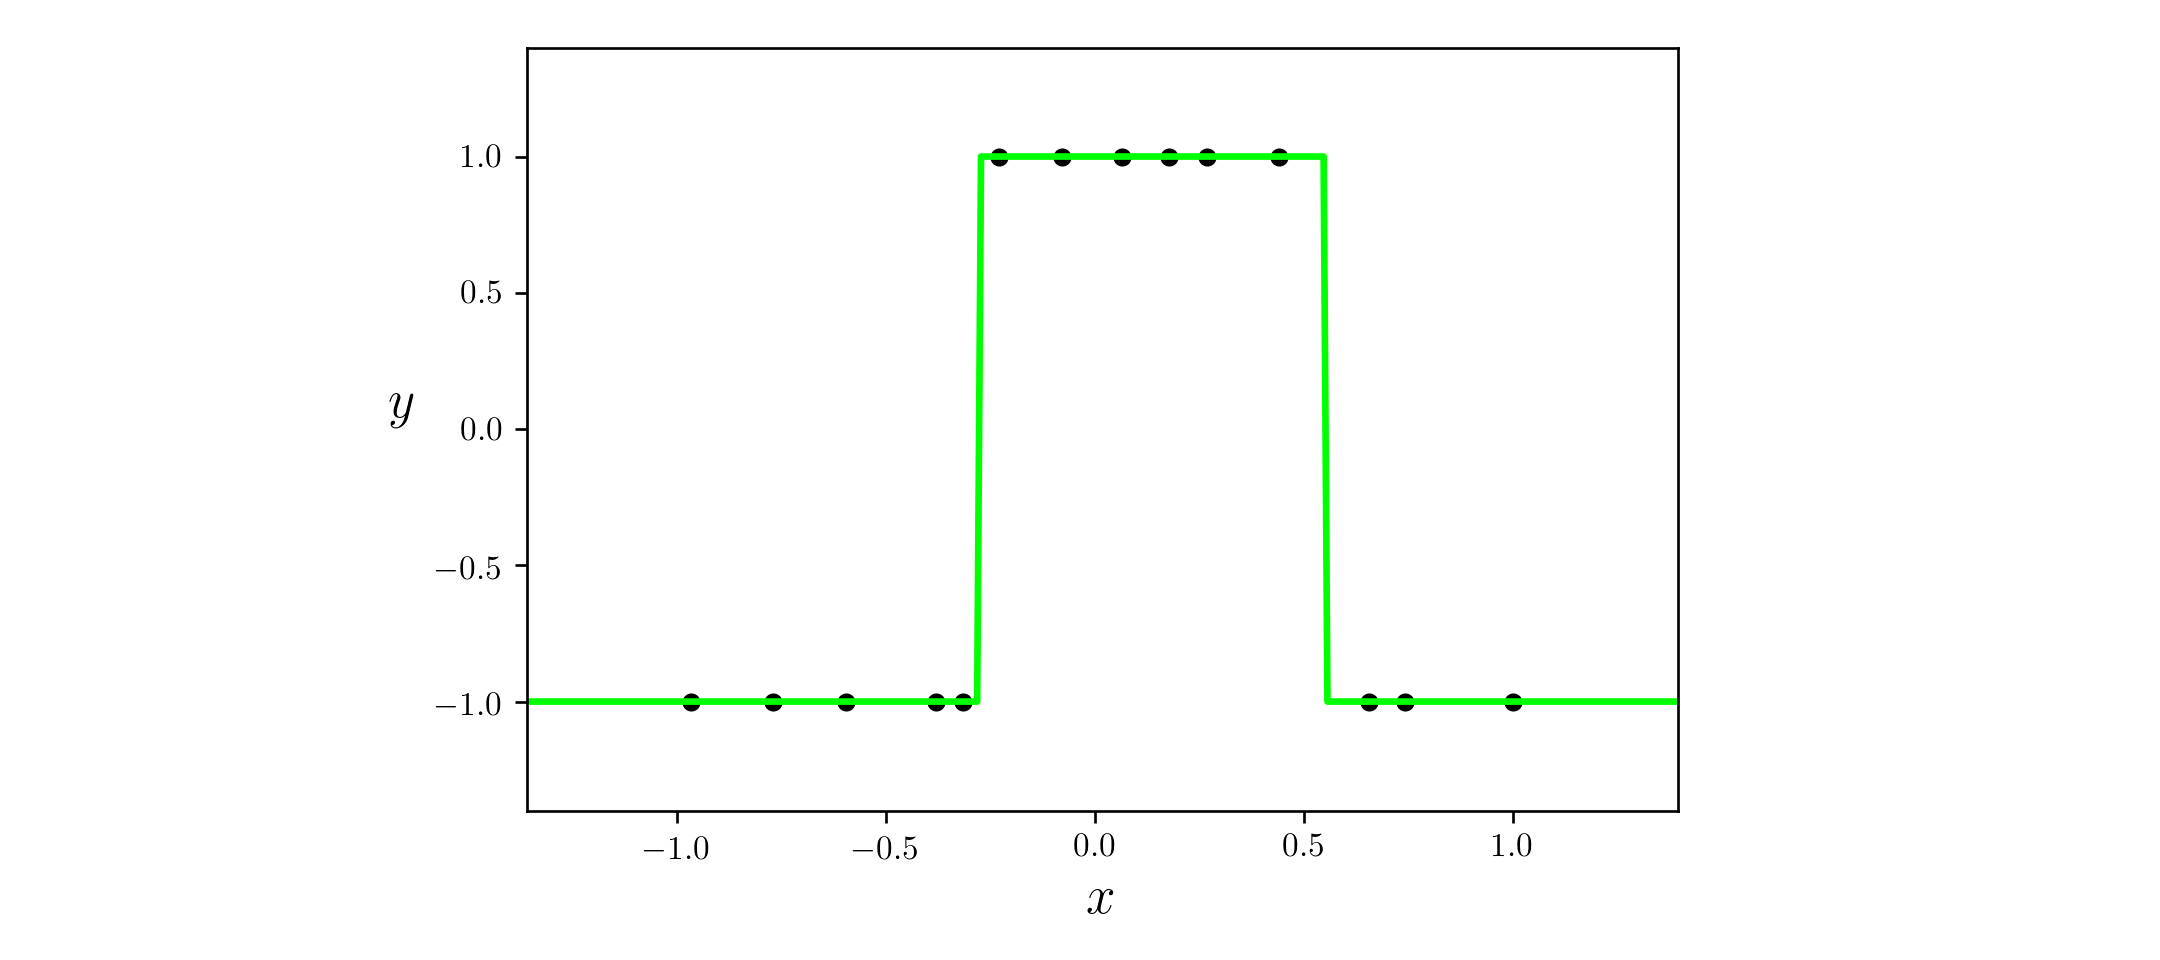

In [73]:
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

# two-class classification two-dimensional input

<IPython.core.display.Javascript object>


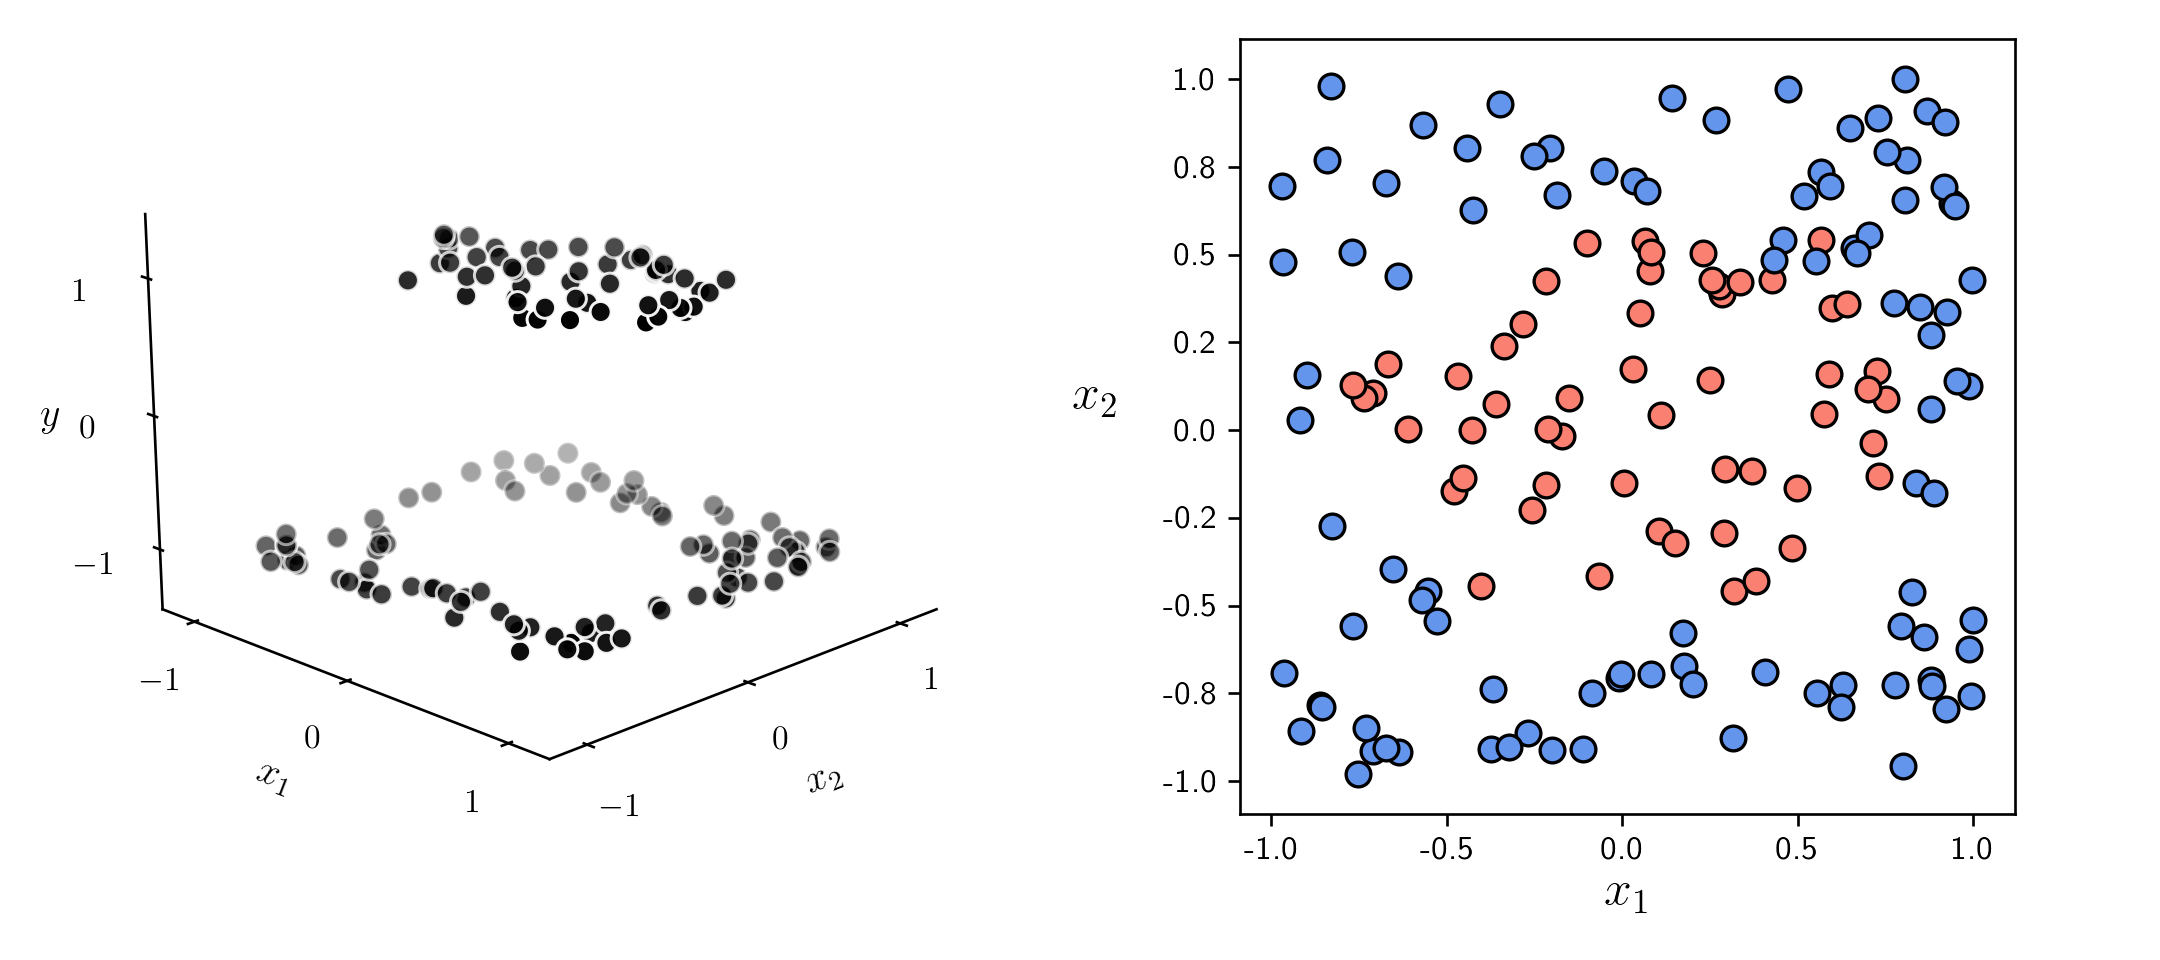

In [7]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + 'ellipse_2class_data.csv')
x = demo.x.T
y = demo.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

In [81]:
# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

In [7]:
# compute transformation on entire set of inputs
def feature_transforms(x): 
    # container for stump transformed data
    N = x.shape[0]
    P = x.shape[1]
    S = len(splits)
    x_transformed = np.zeros((S,P))
    
    # loop over points and transform each individually
    for pt in range(P):
        x_n = x[:,pt]

        # loop over the stump collectionand calculate weighted contribution
        for u in range(len(splits)):
            # get current stump f_u
            split = splits[u]
            level = levels[u]
            dim = dims[u]

            ### our stump function f_u(x)
            if x_n[dim] <= split:  # lies to the left - so evaluate at left level
                x_transformed[u][pt] = level[0]
            else:
                x_transformed[u][pt]  = level[1]
    return x_transformed

In [82]:
x_t = feature_transforms(x)

In [94]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 2; alpha_choice = 10**(-2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its,algo = 'newtons_method')
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


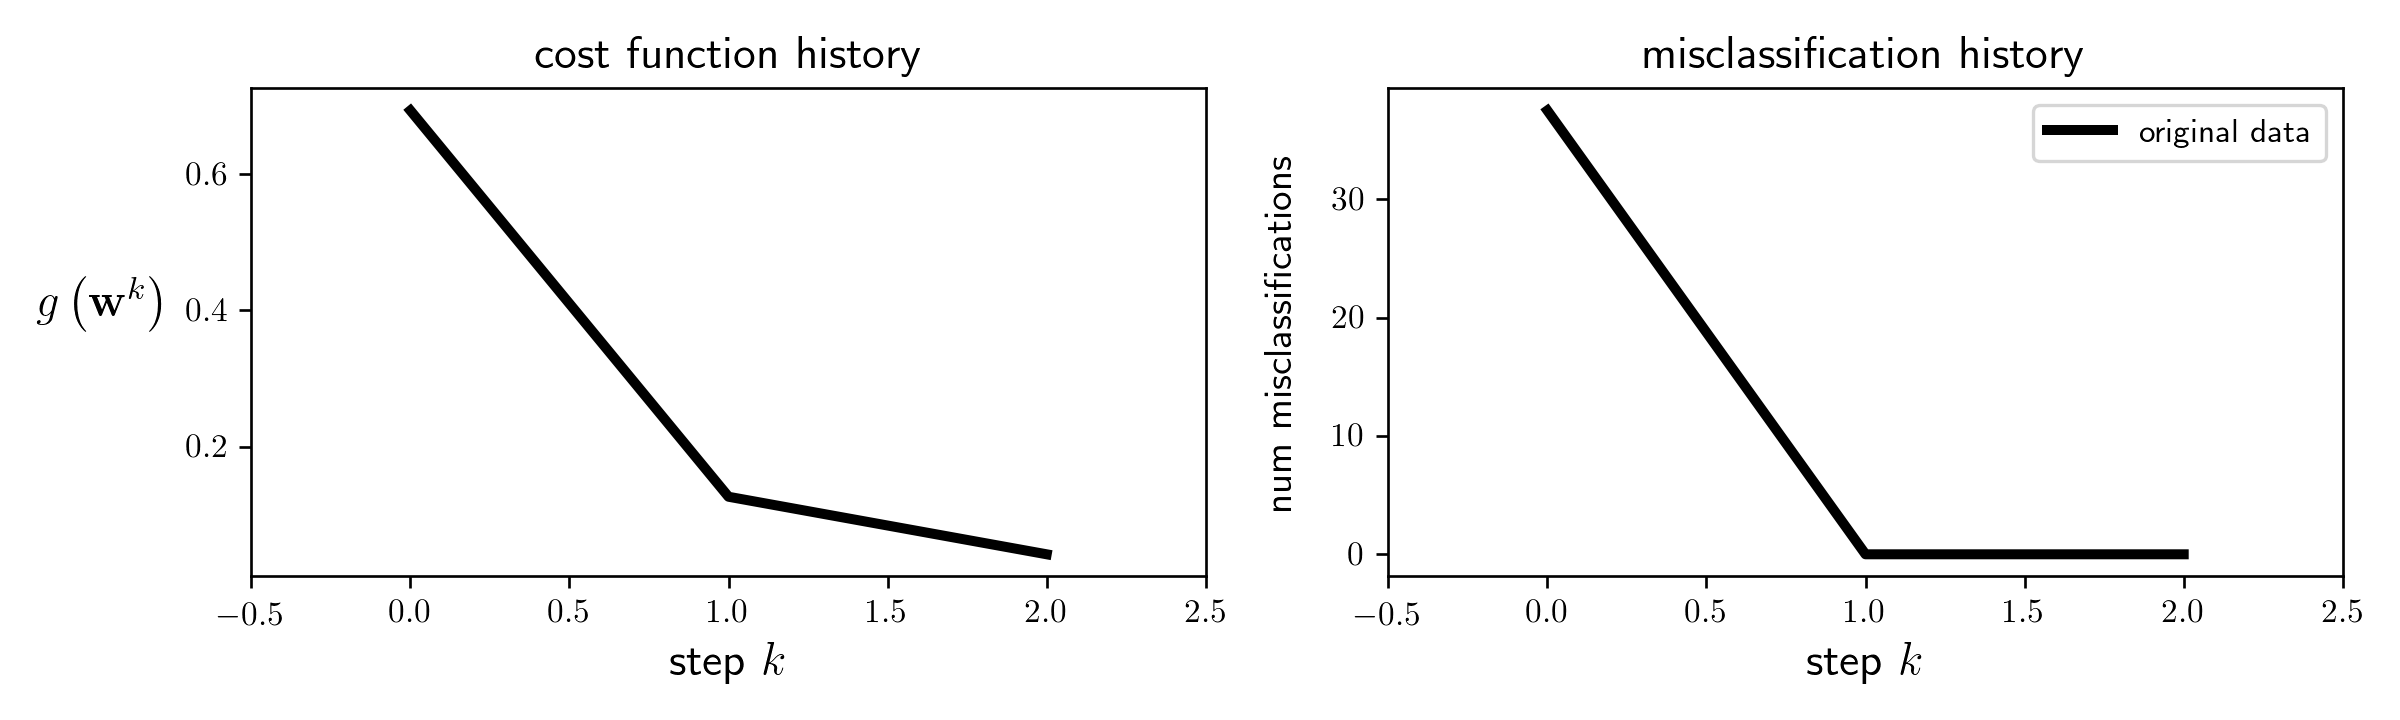

In [95]:
plotter = classif_history_plotter.Visualizer()
plotter.plot_cost_histories([run.cost_history],[count_history],start = 0,points = False,labels = ['original data'])

<IPython.core.display.Javascript object>


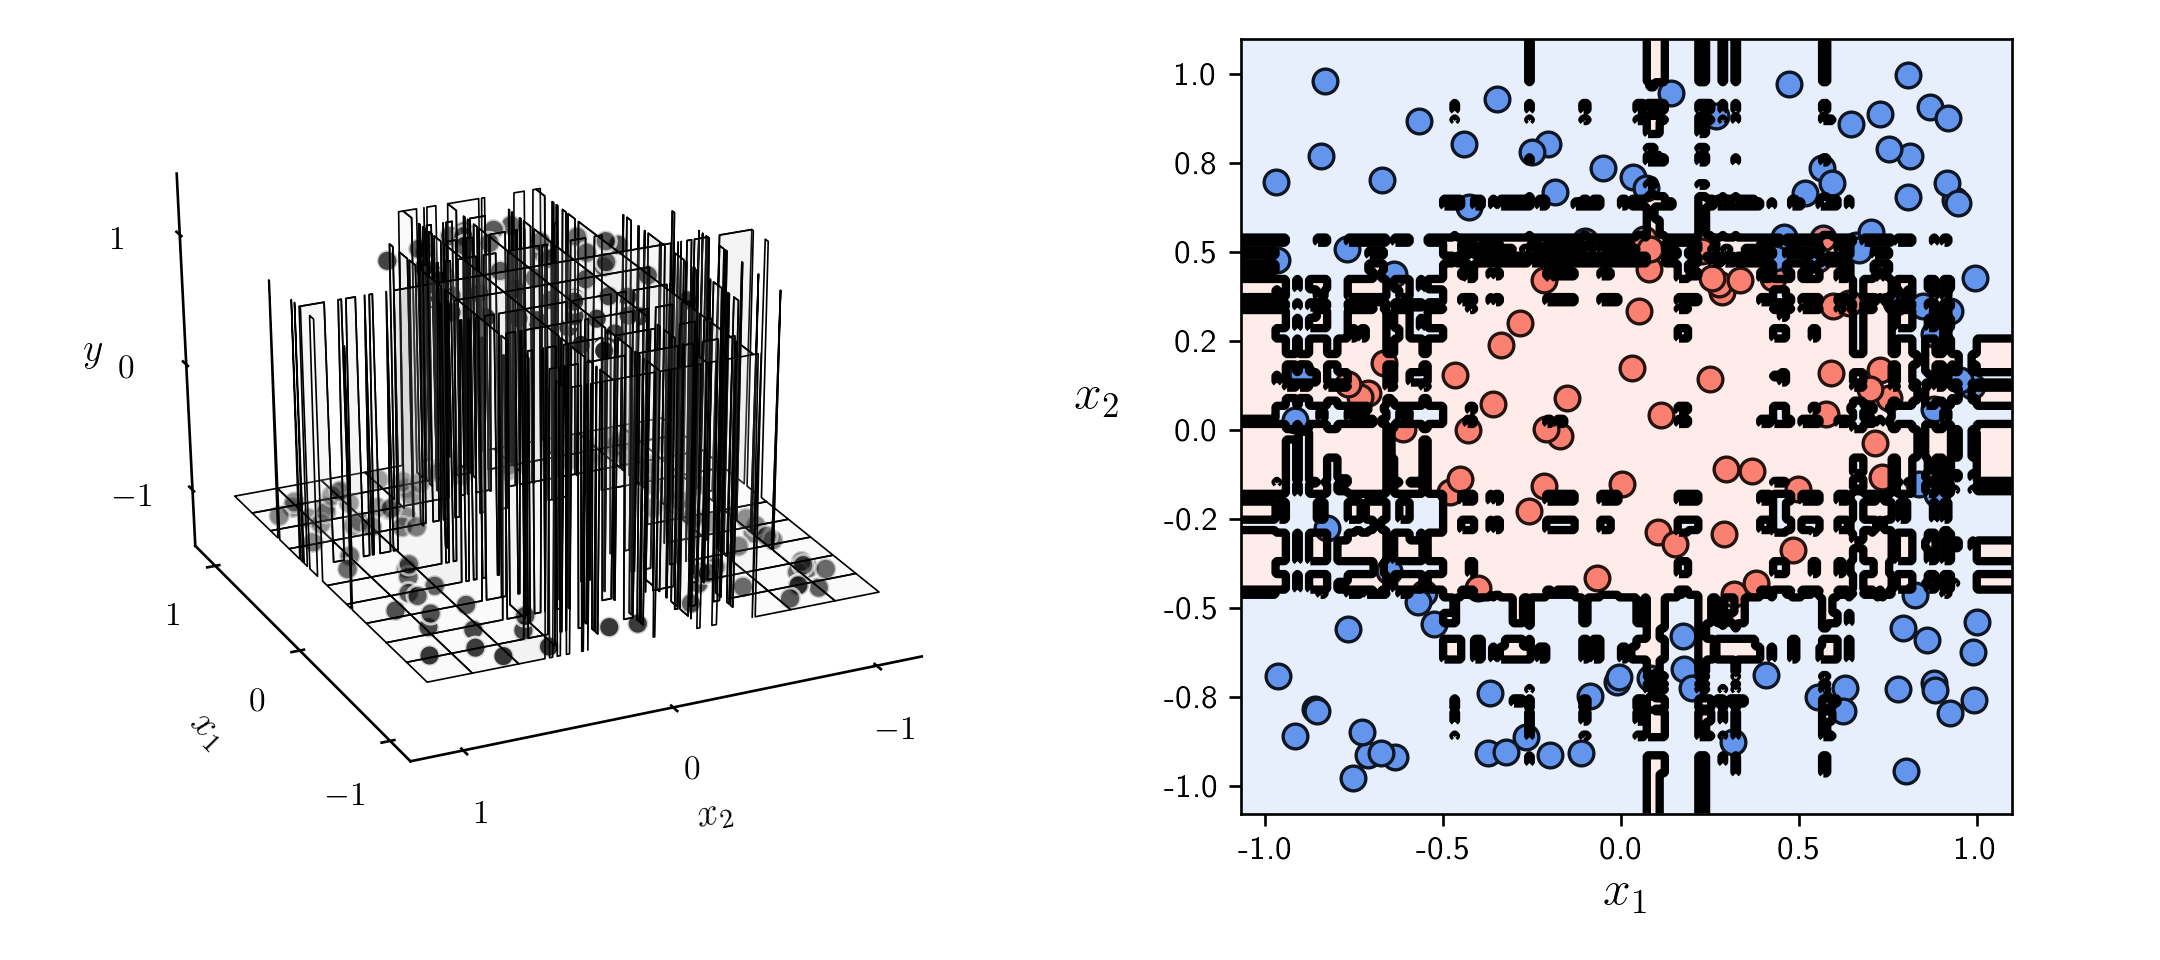

In [96]:
# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_simple(w_best,run,view = [30,155])

In [106]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 1000; alpha_choice = 10**(-2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


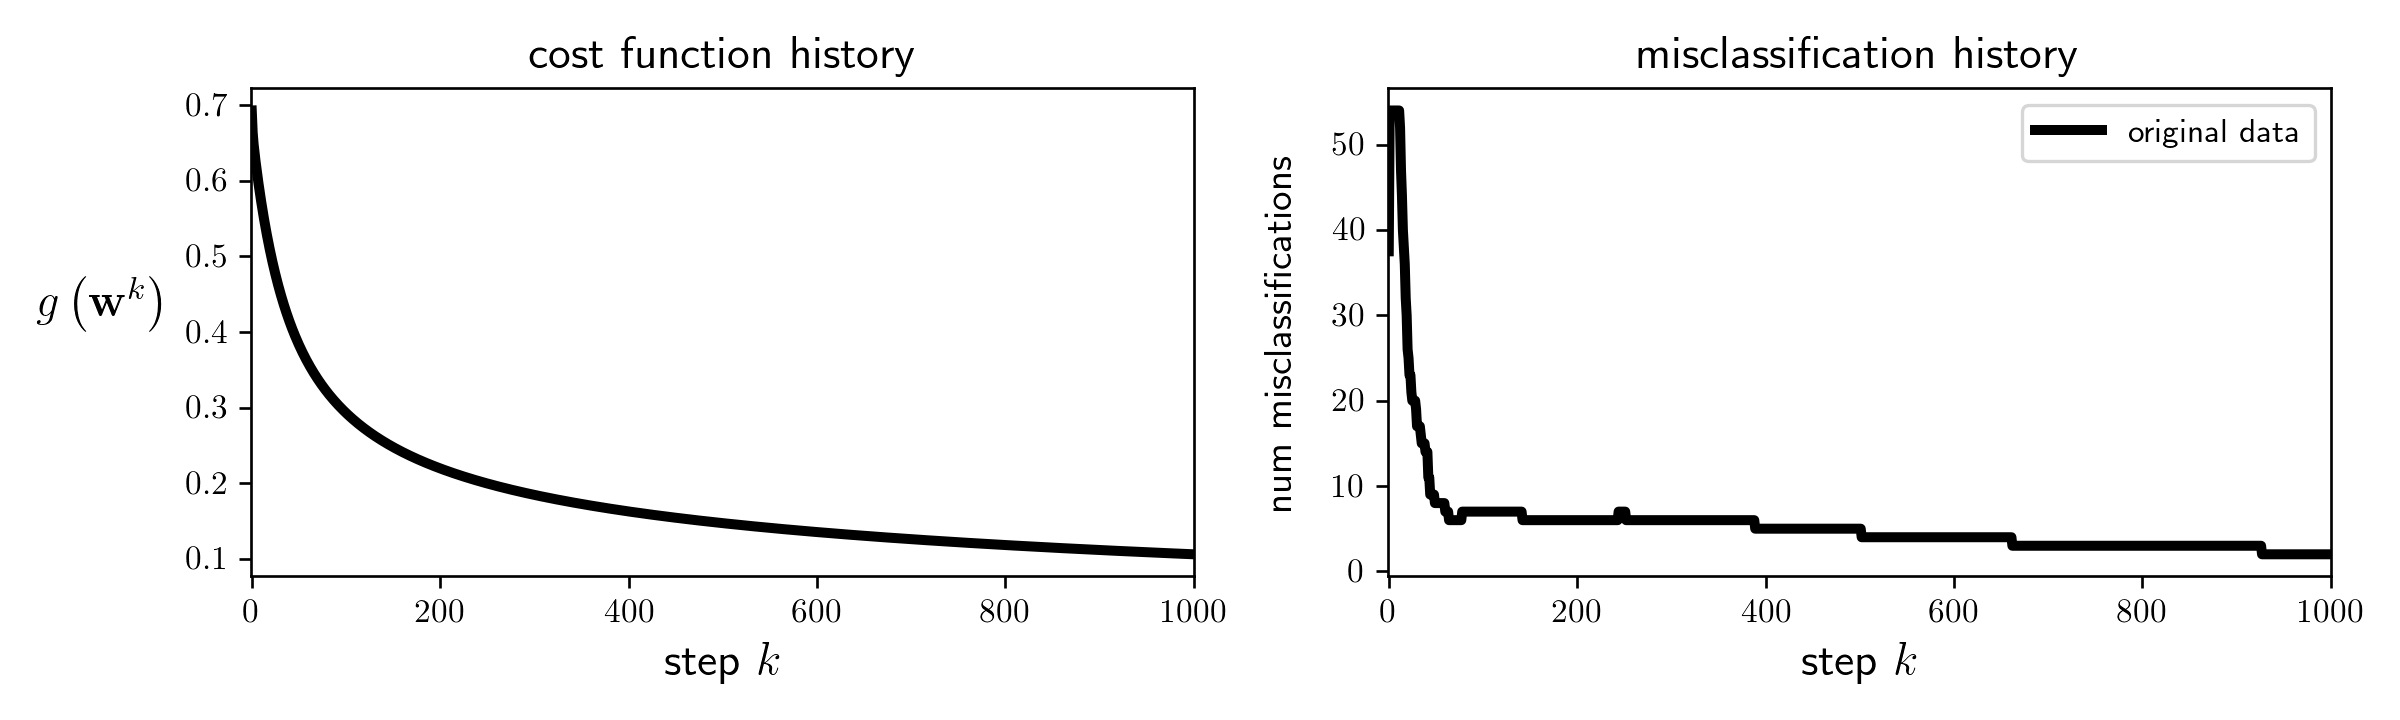

In [107]:
plotter = classif_history_plotter.Visualizer()
plotter.plot_cost_histories([run.cost_history],[count_history],start = 0,points = False,labels = ['original data'])

<IPython.core.display.Javascript object>


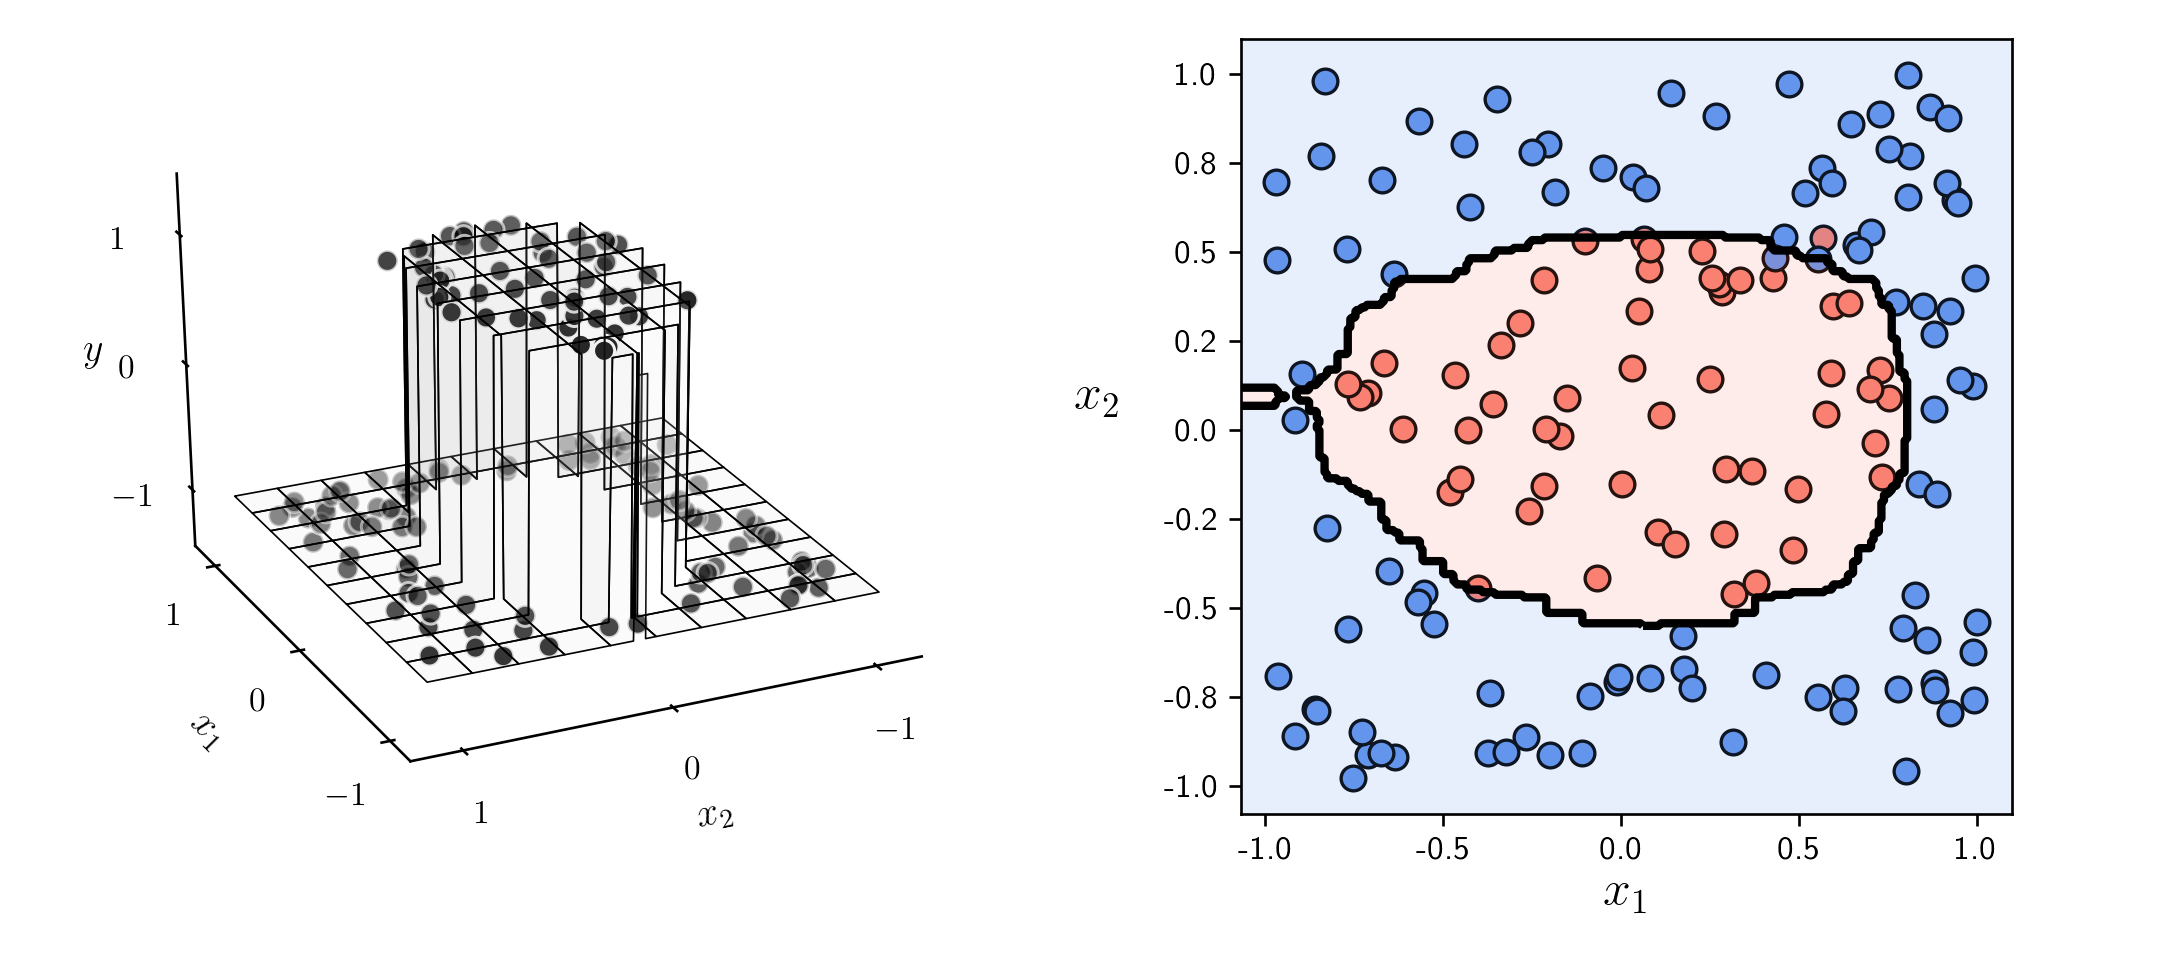

In [108]:
# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_simple(w_best,run,view = [30,155])

<IPython.core.display.Javascript object>


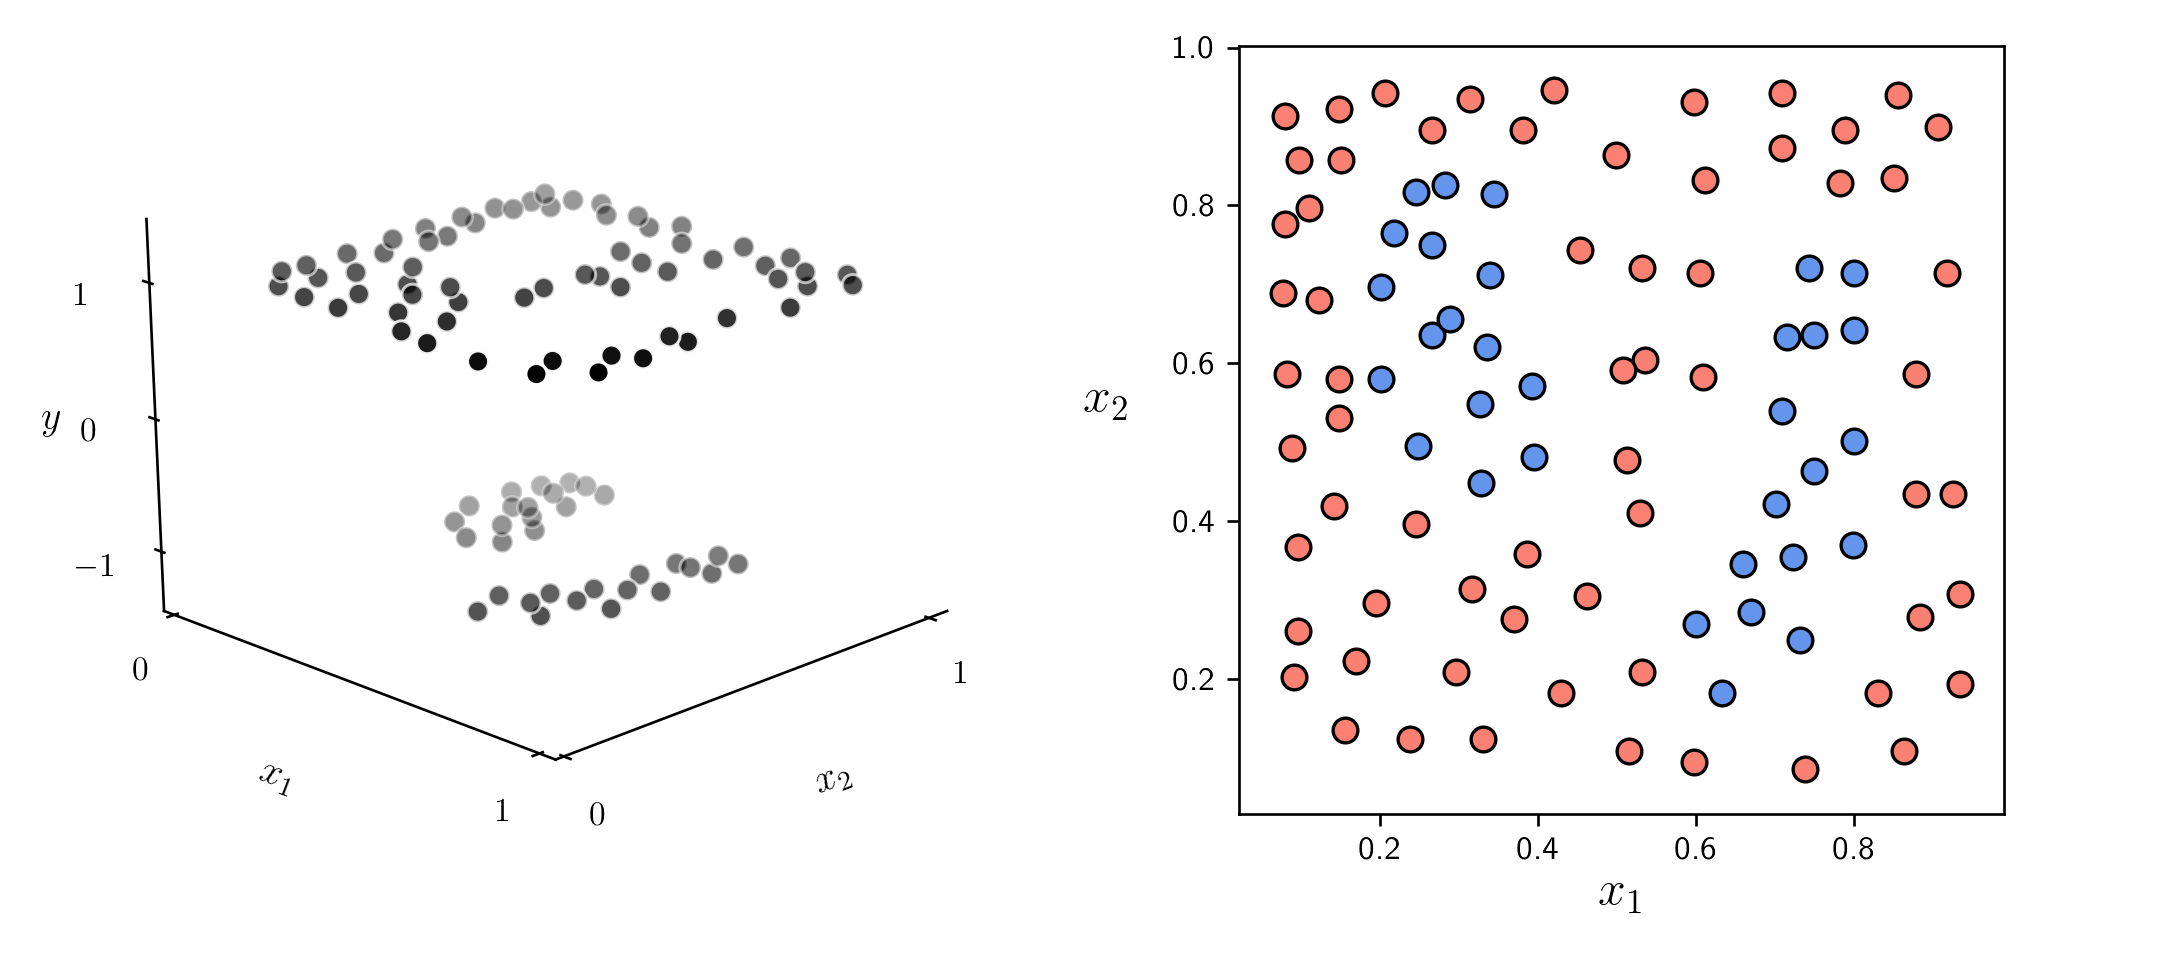

In [4]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '2eggs_data.csv')
x = demo.x.T
y = demo.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data()

In [5]:
# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

In [6]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 100; alpha_choice = 10**(-2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


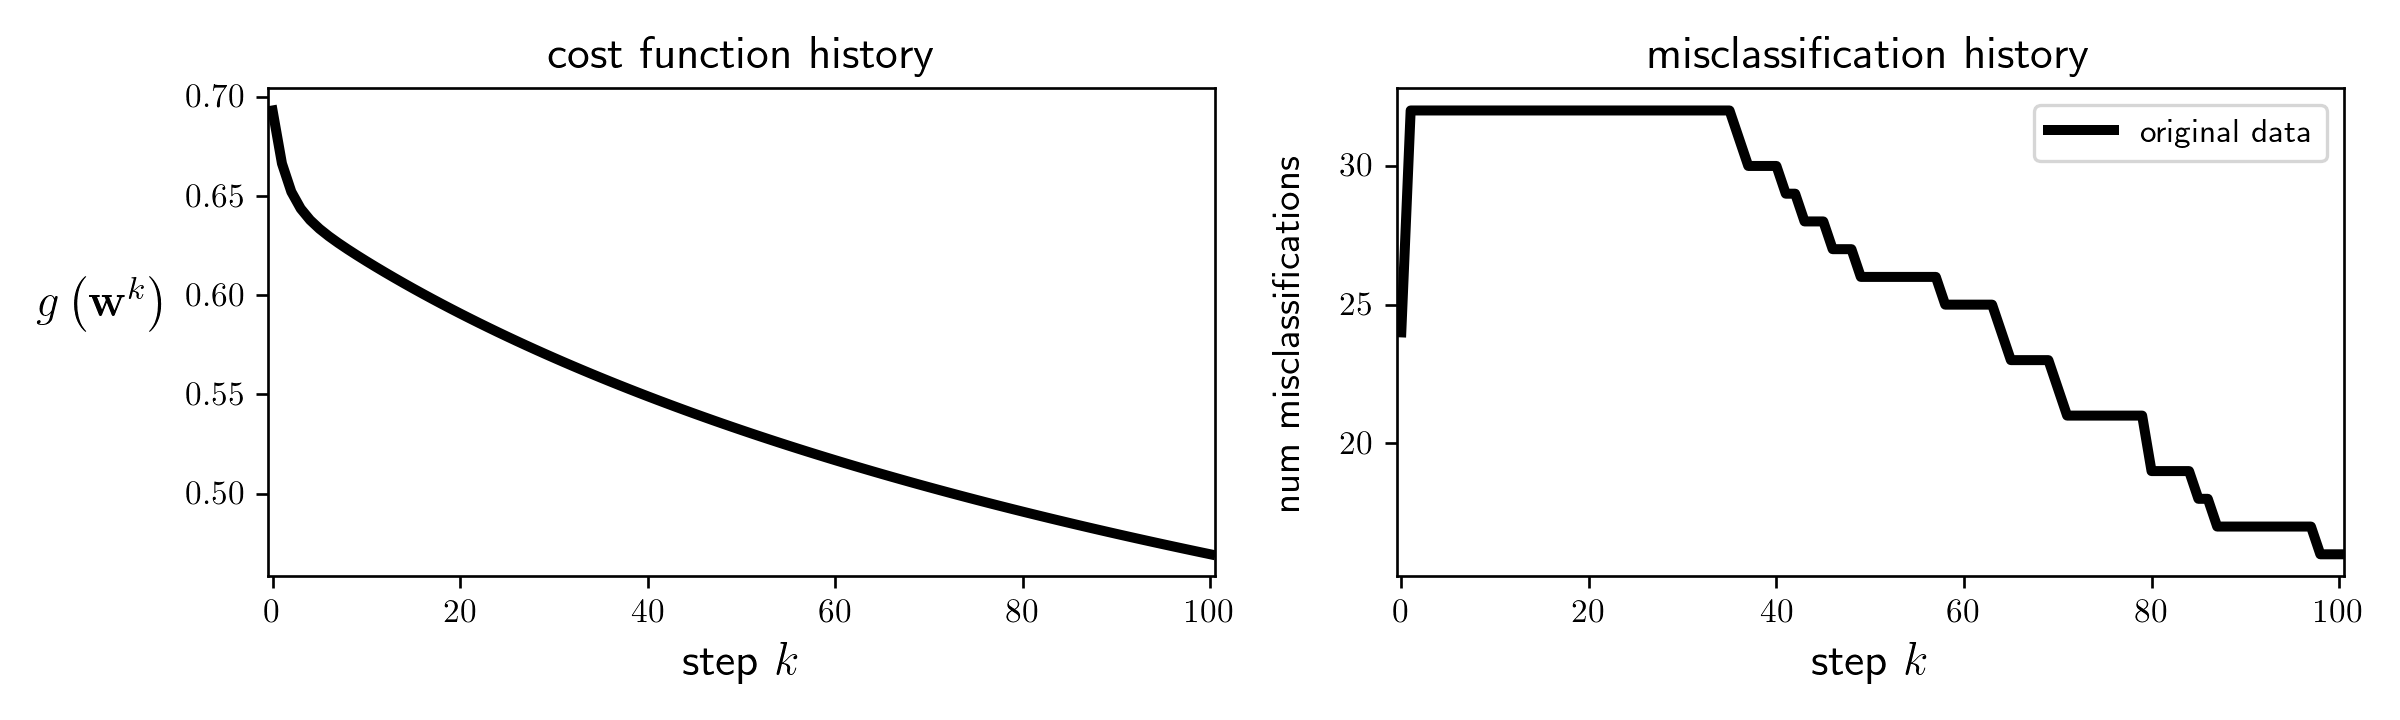

In [7]:
plotter = classif_history_plotter.Visualizer()
plotter.plot_cost_histories([run.cost_history],[count_history],start = 0,points = False,labels = ['original data'])

In [8]:
aninmation_demo = nonlib.run_animators.Visualizer(datapath + '2eggs_data.csv')


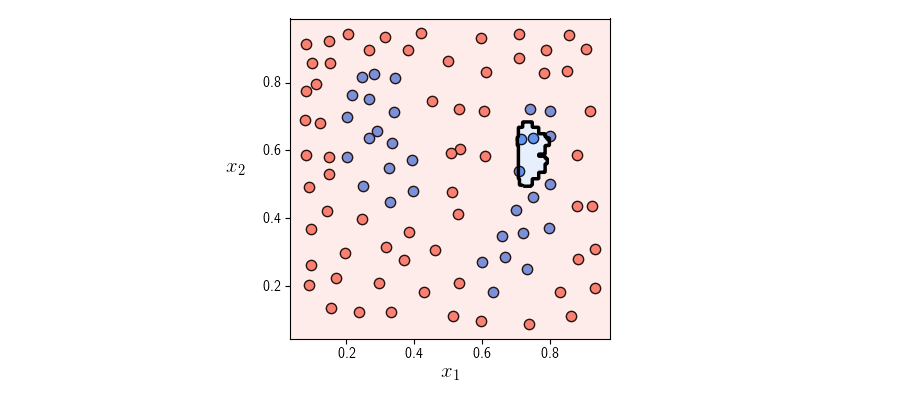
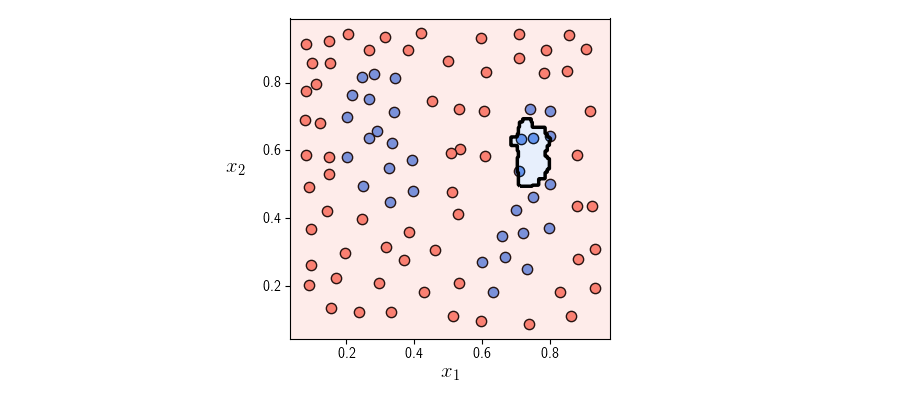
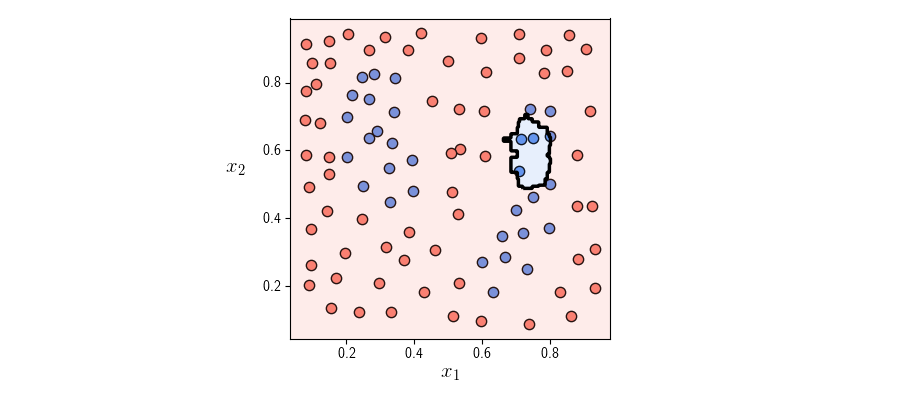
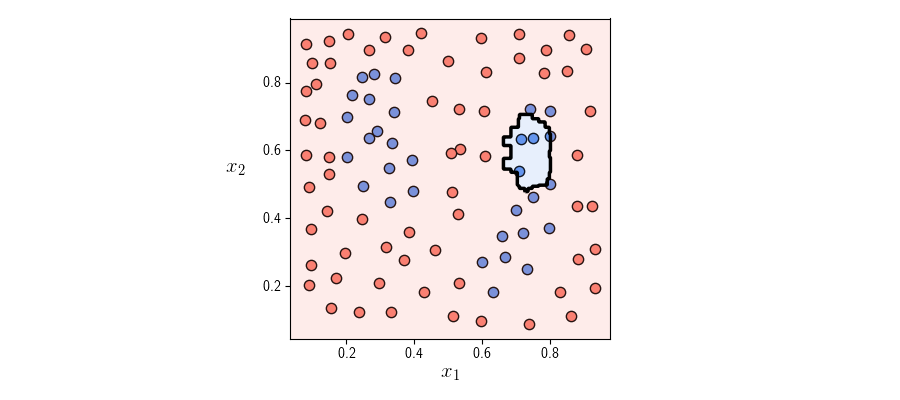
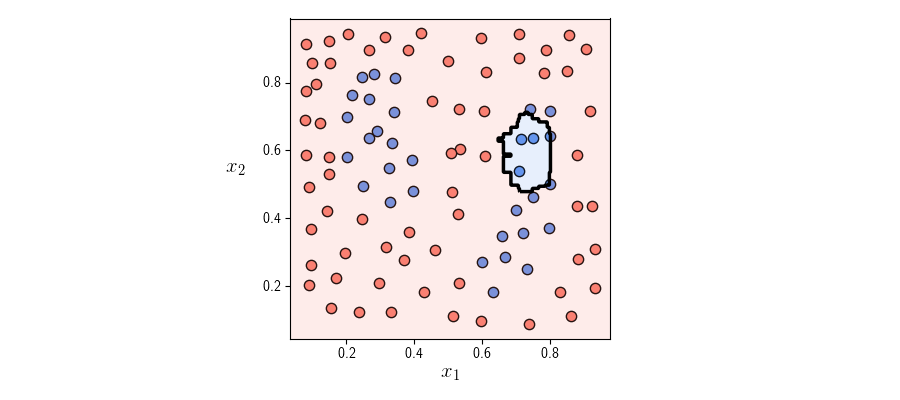
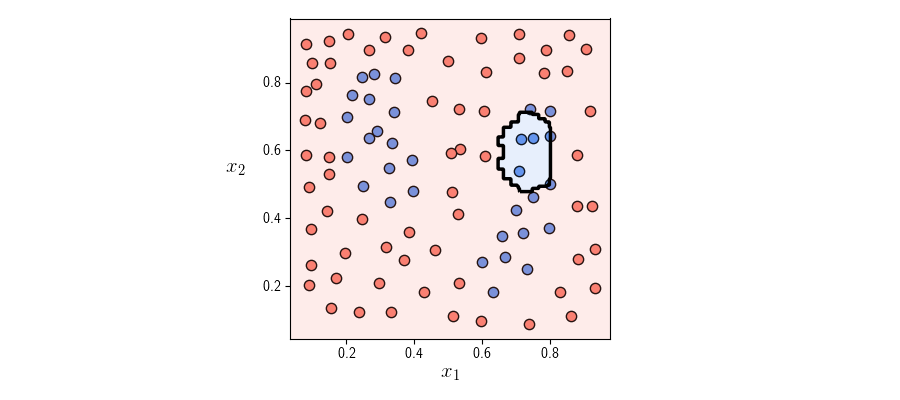
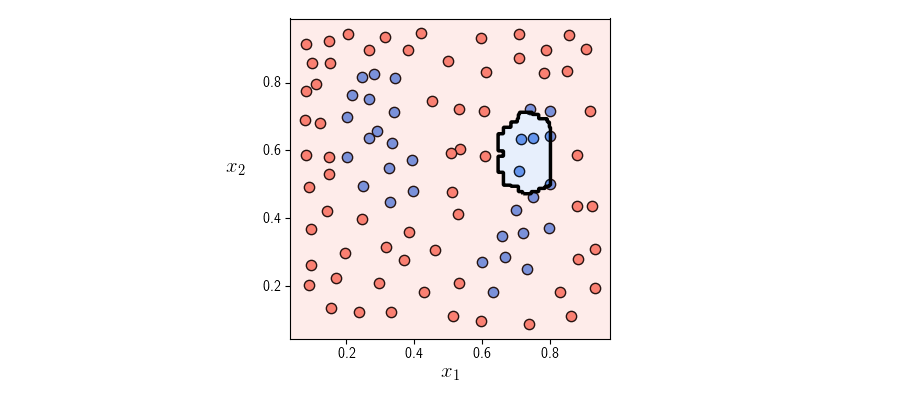
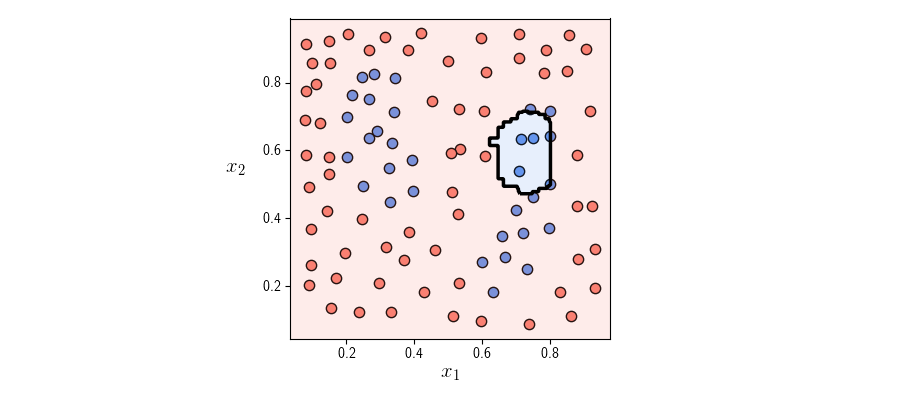
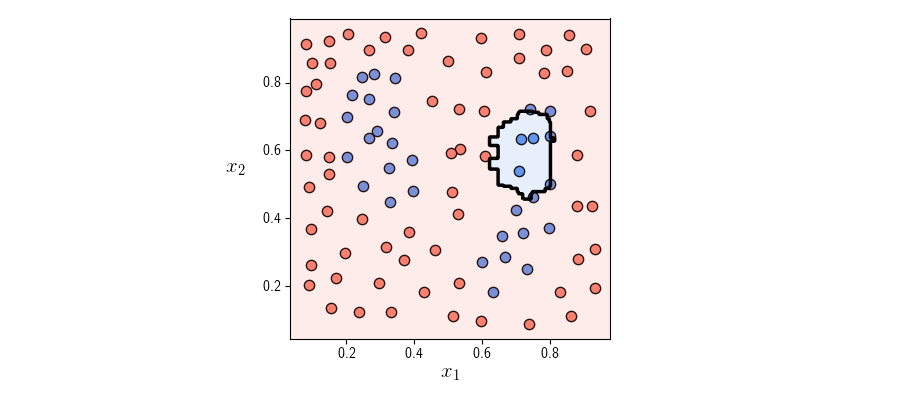
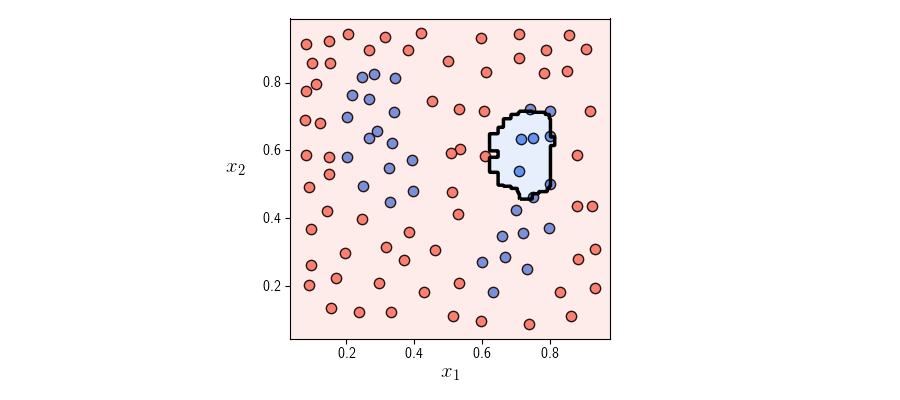
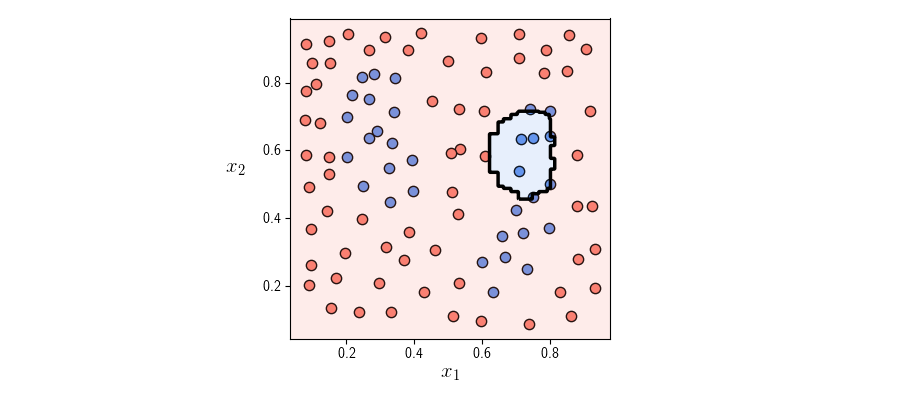
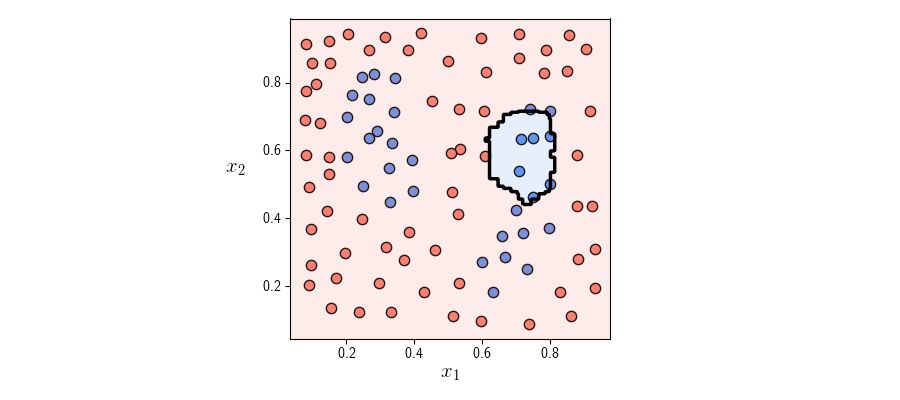
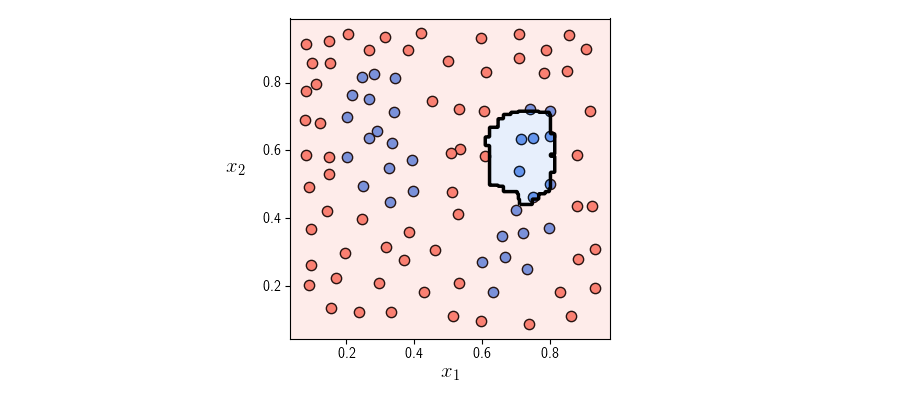
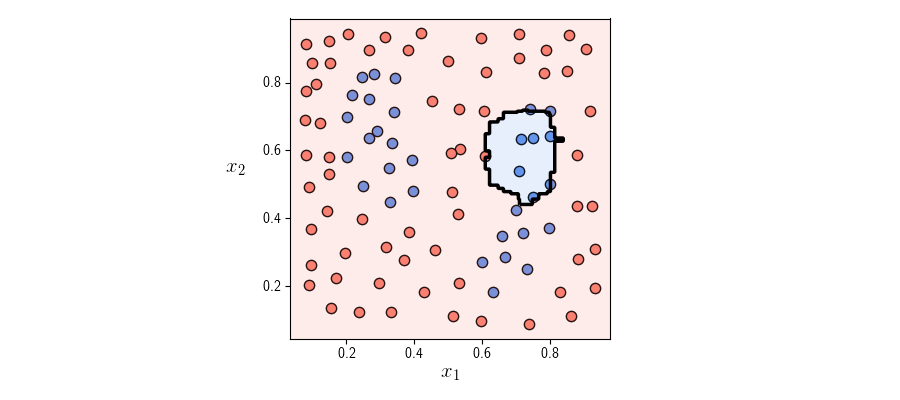
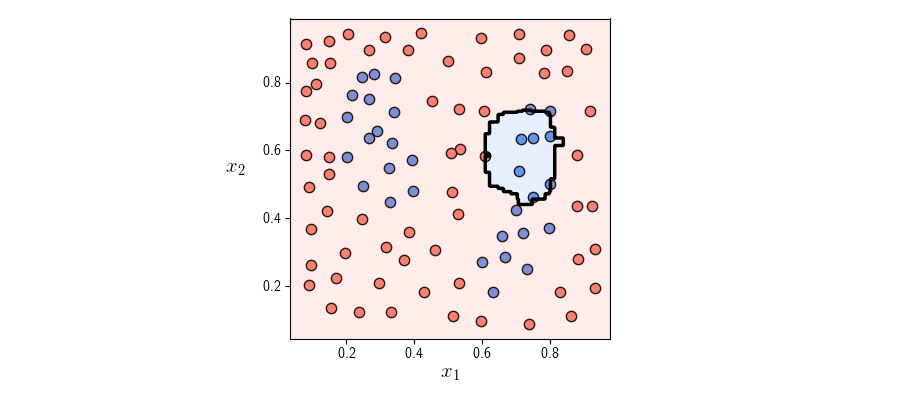
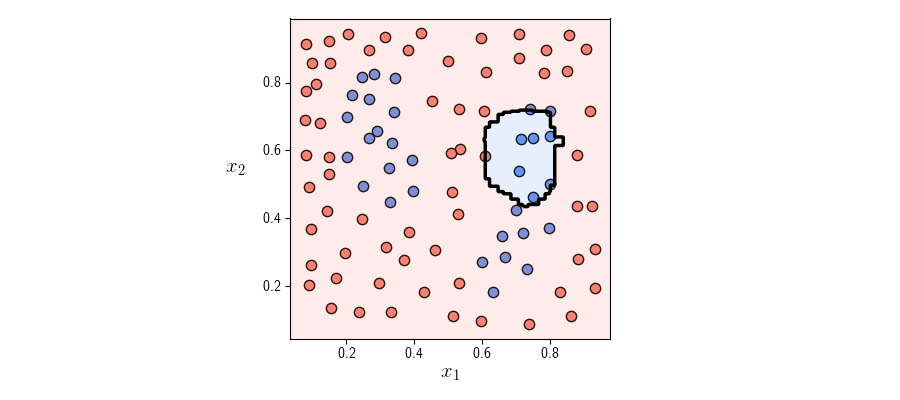
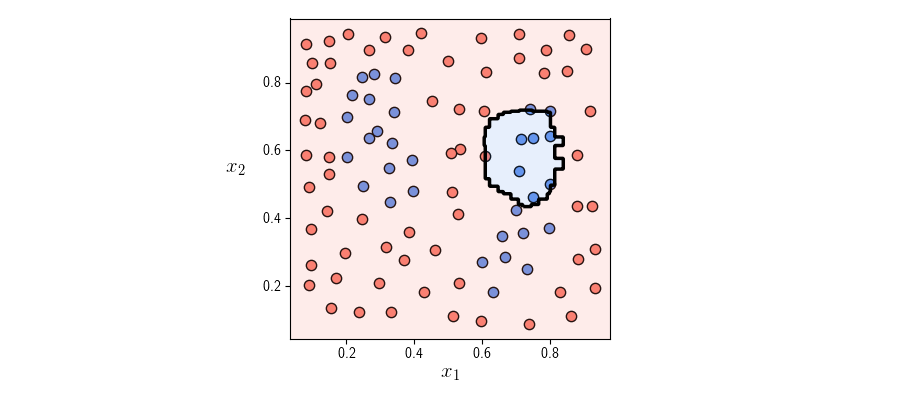
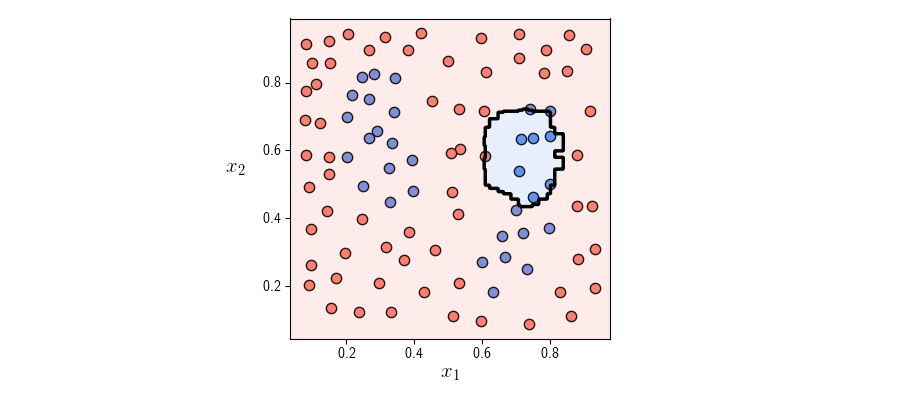
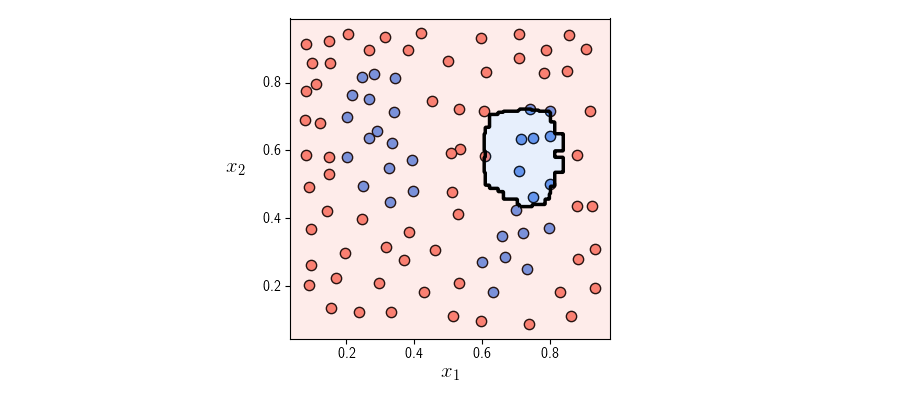
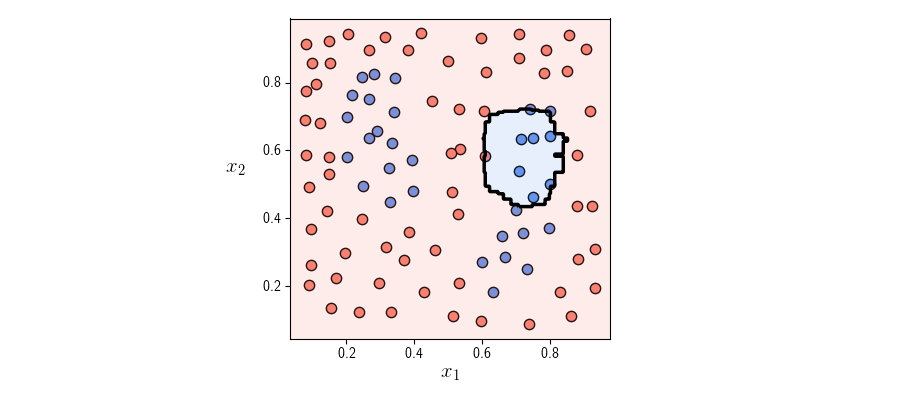
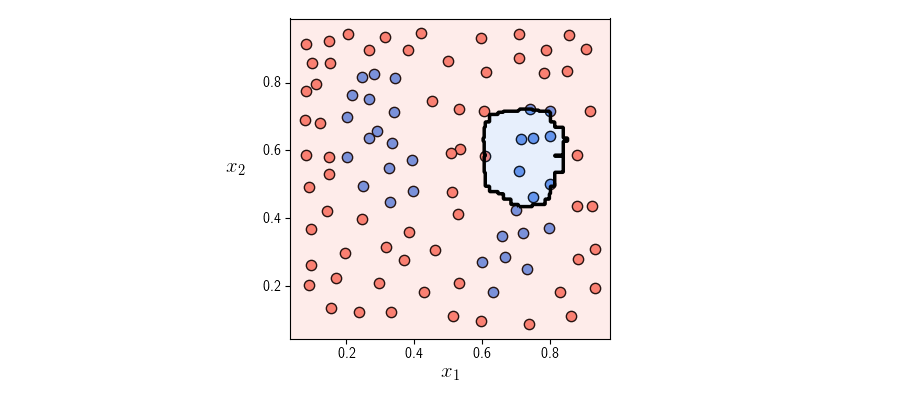
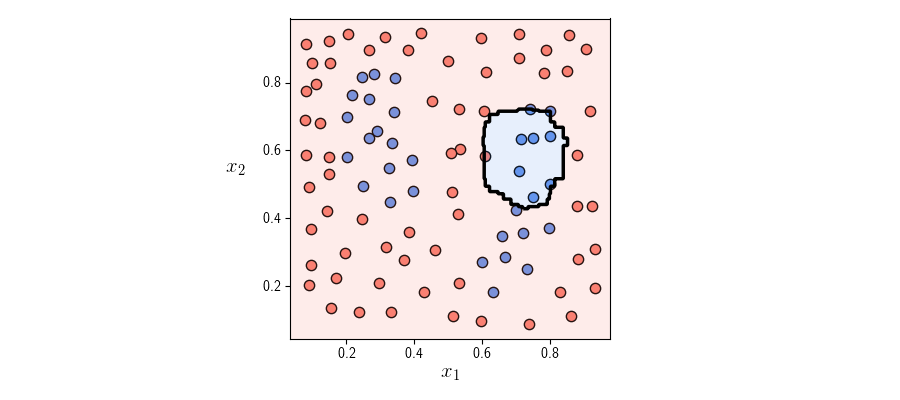
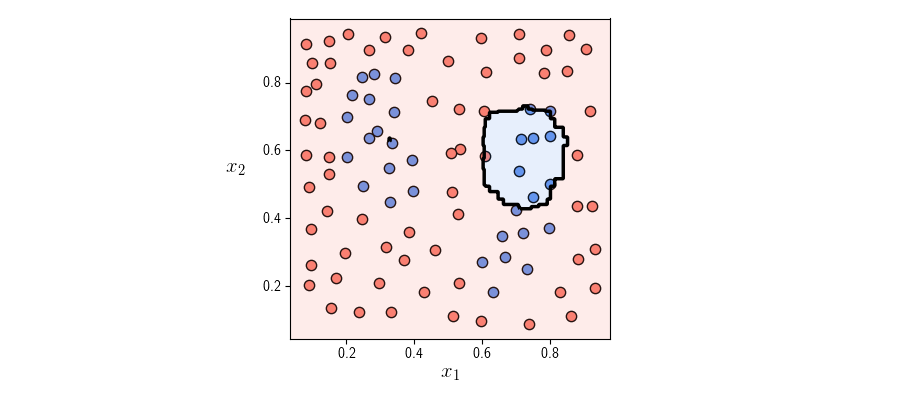
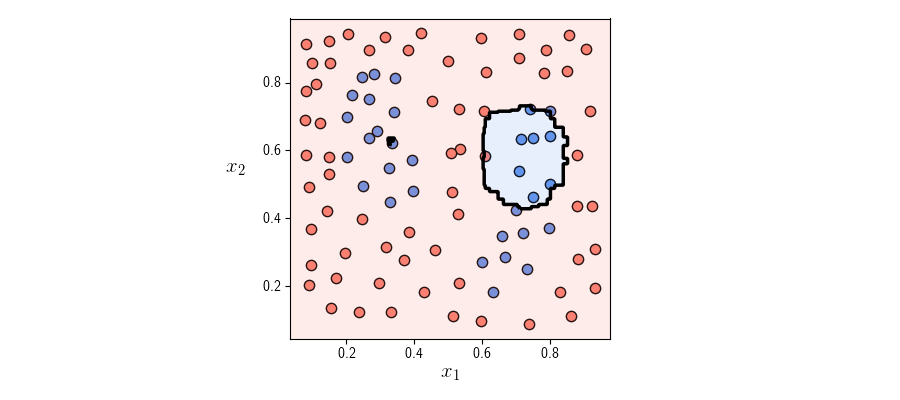
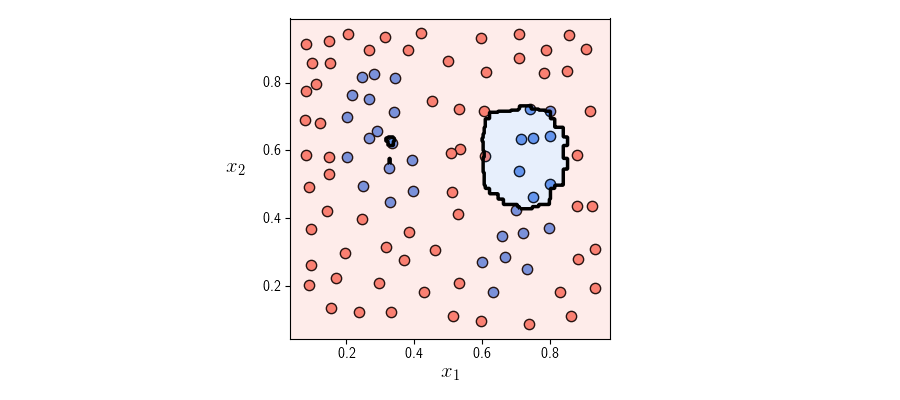
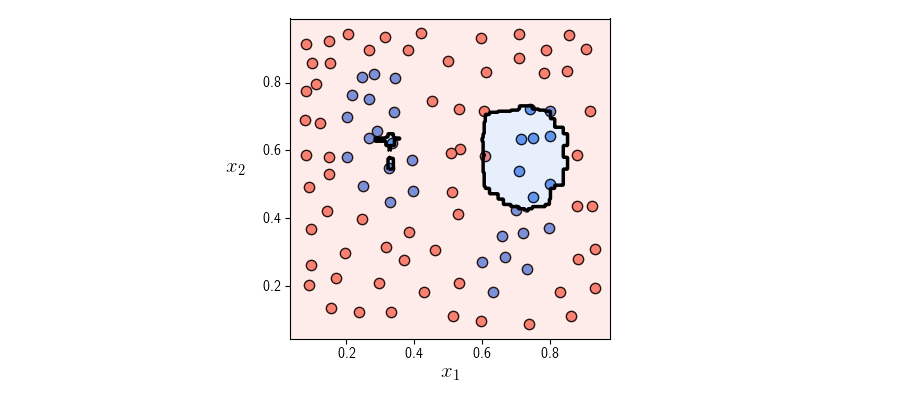
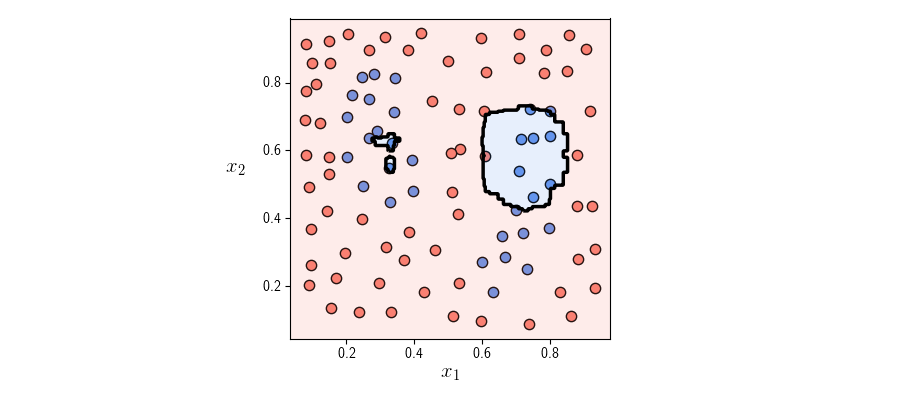
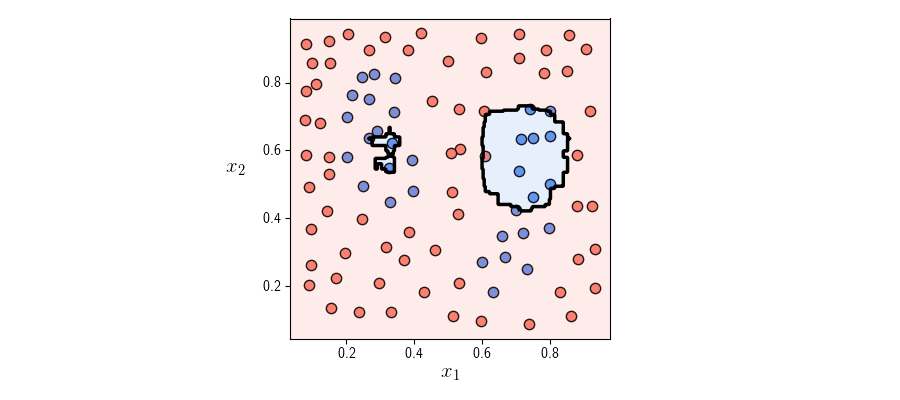
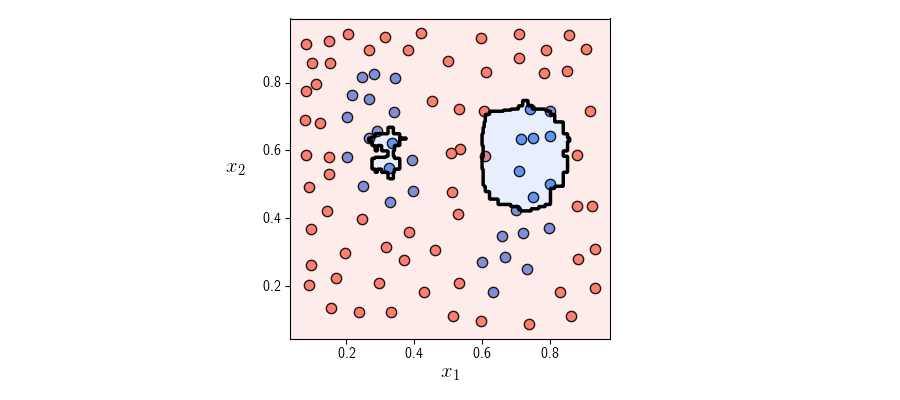
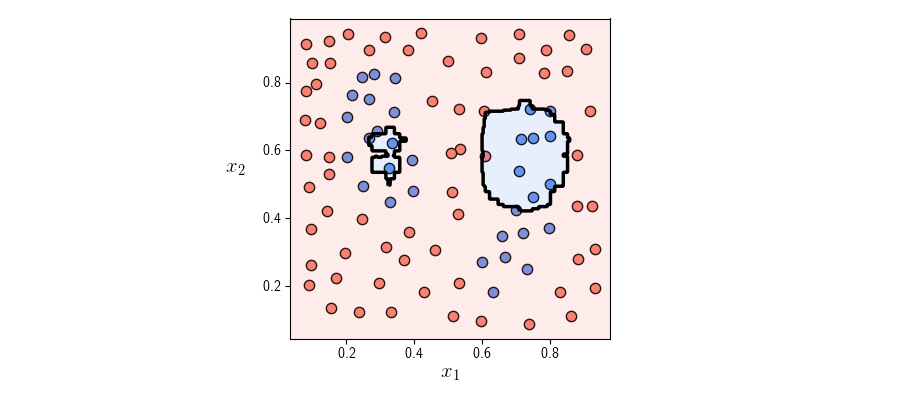
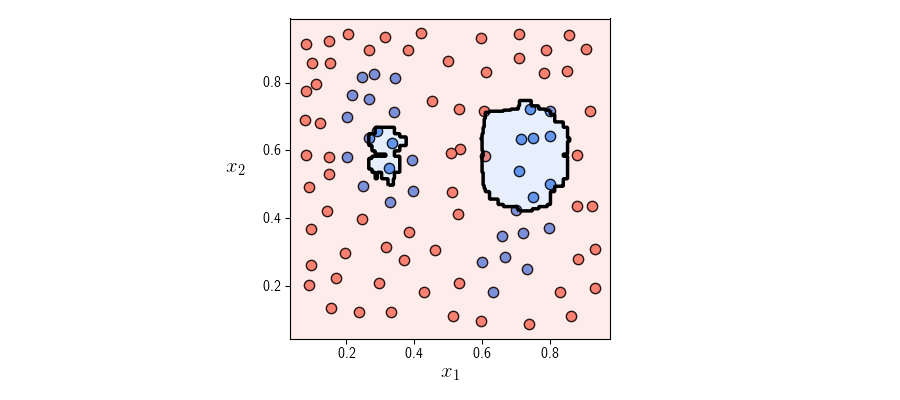
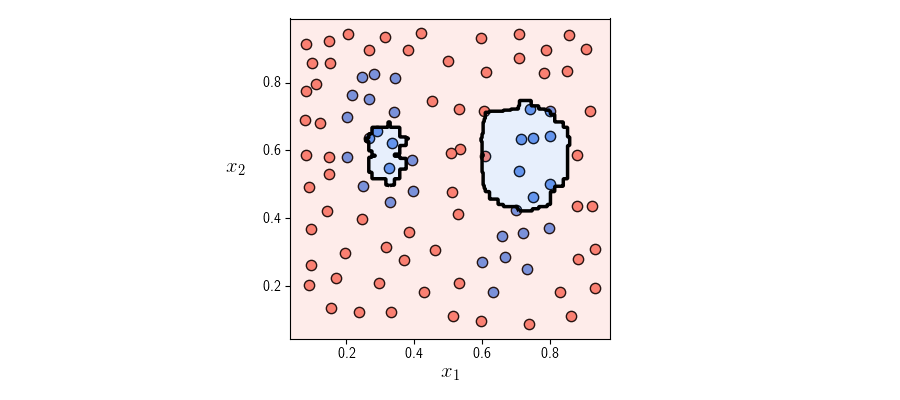
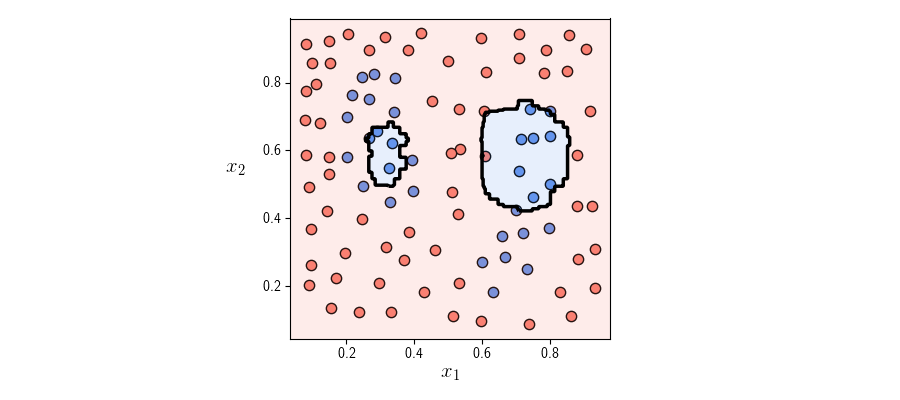
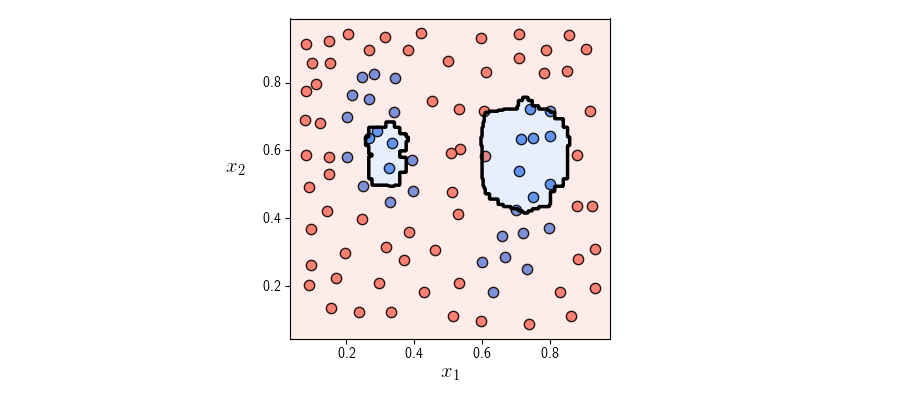
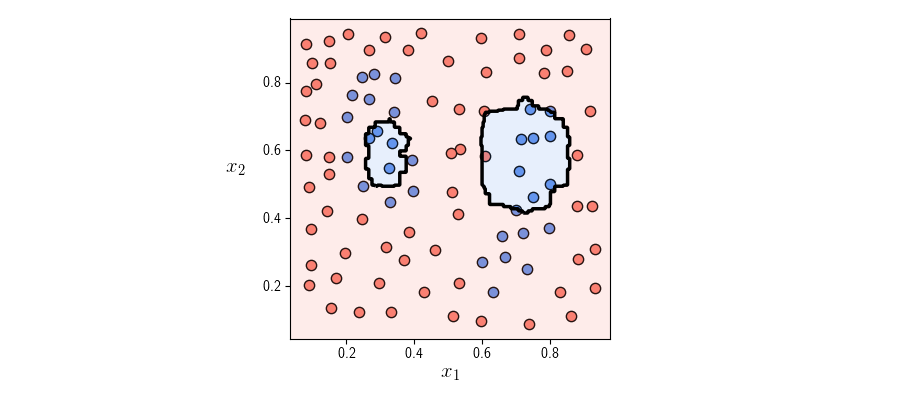
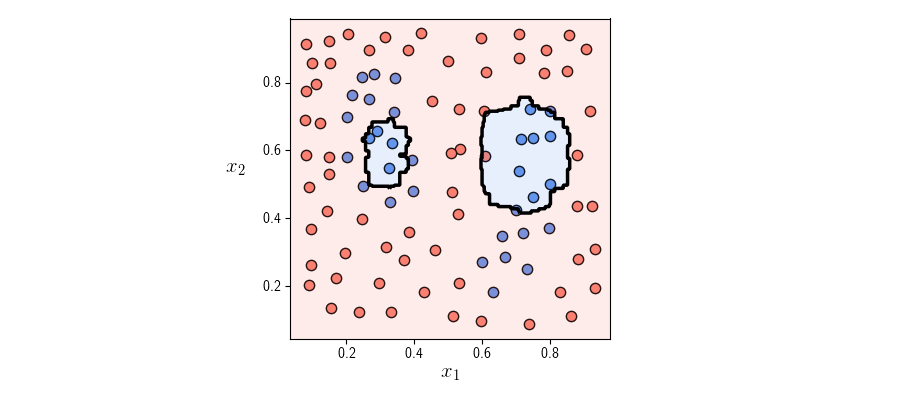
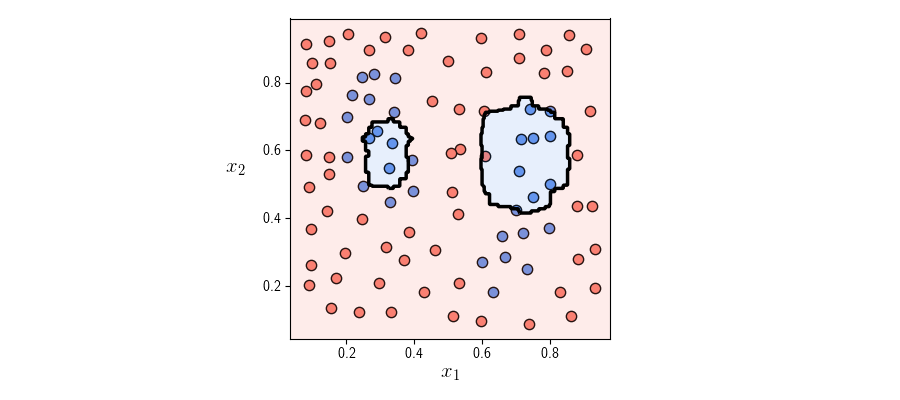
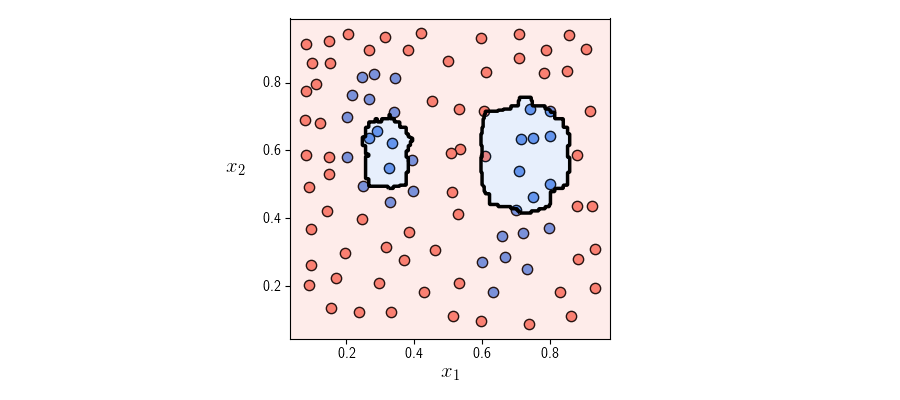
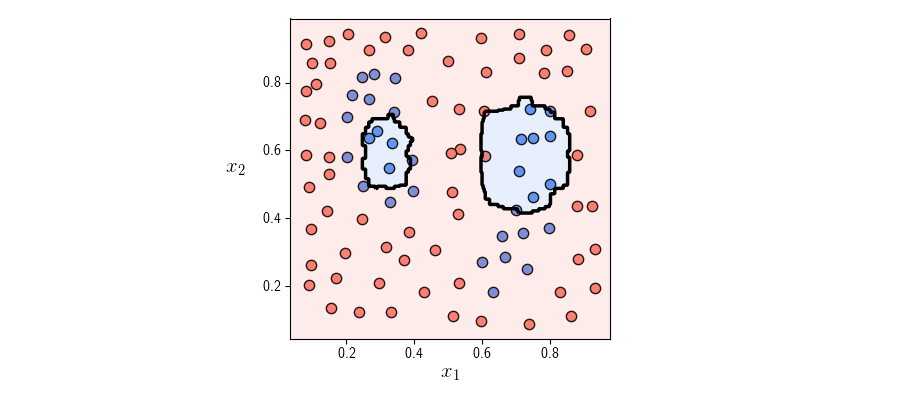
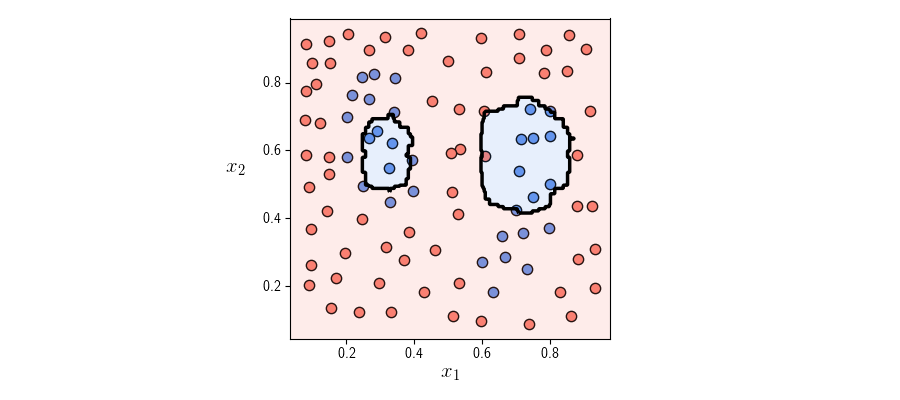
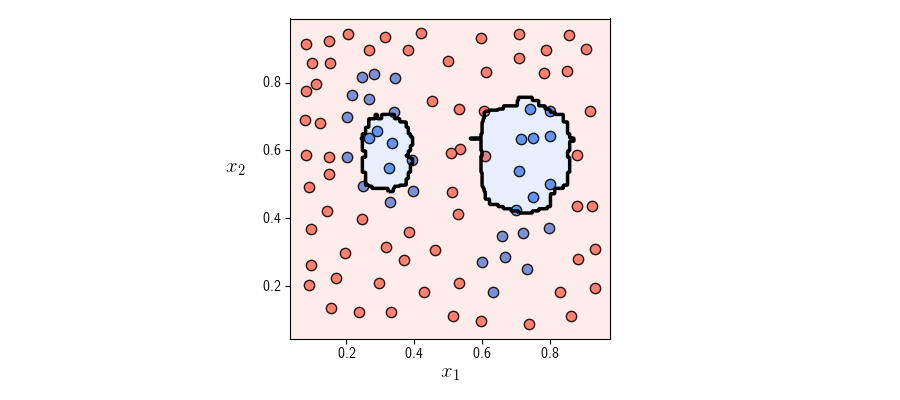
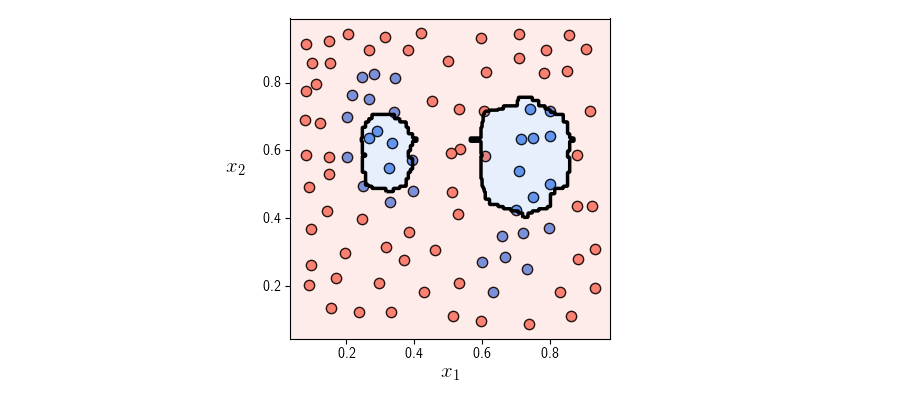
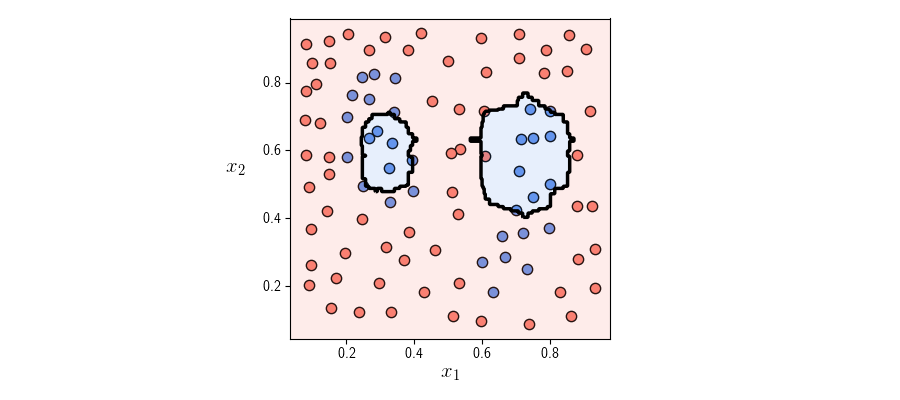
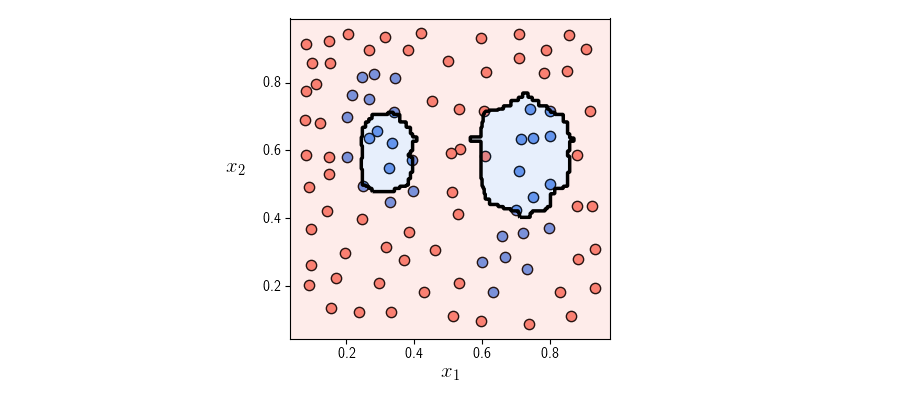
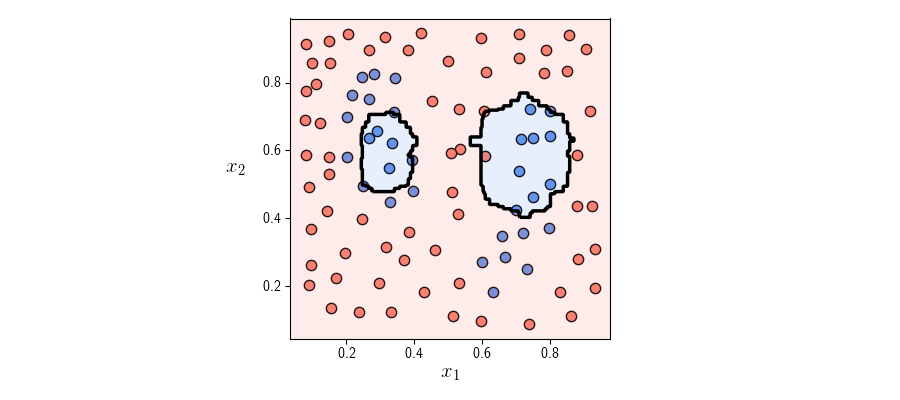
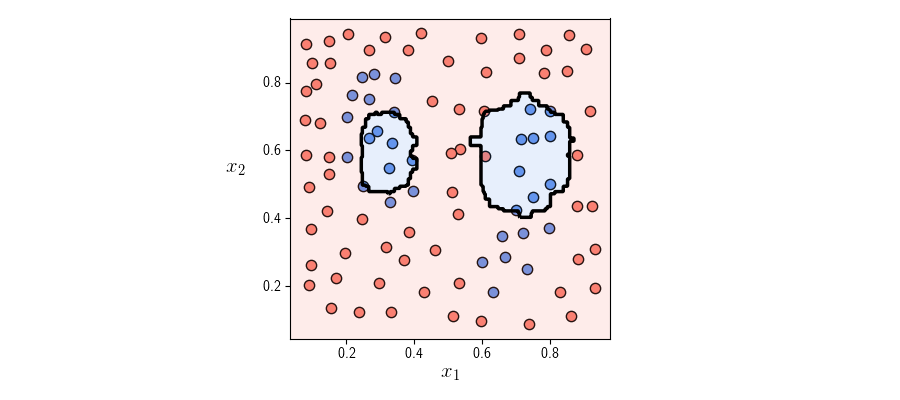
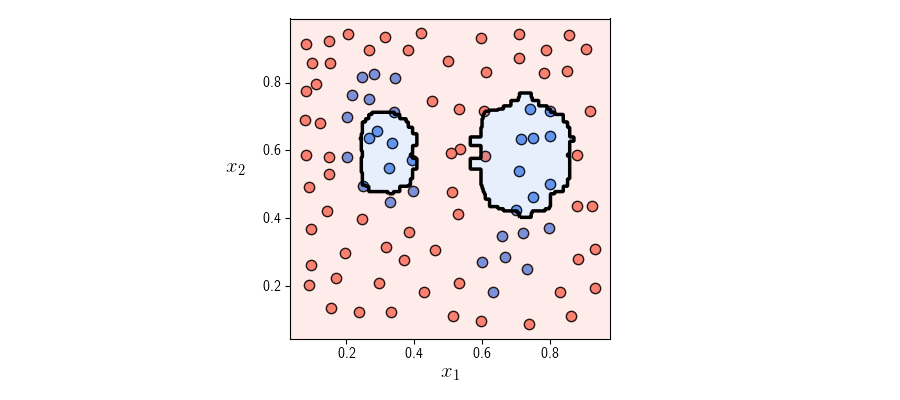
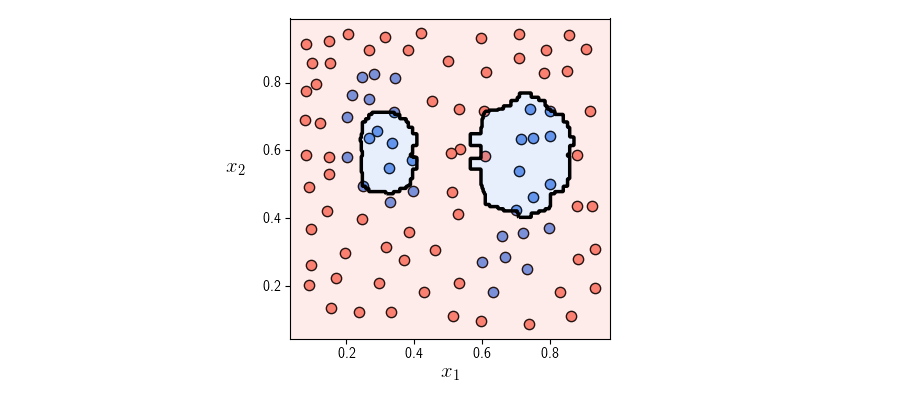
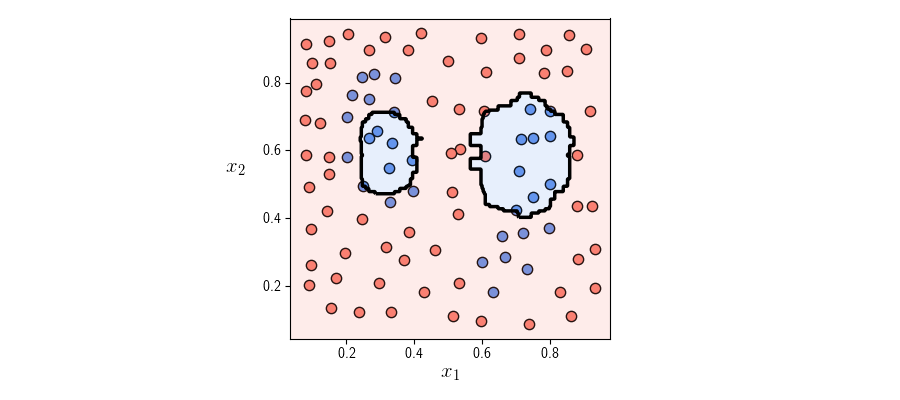
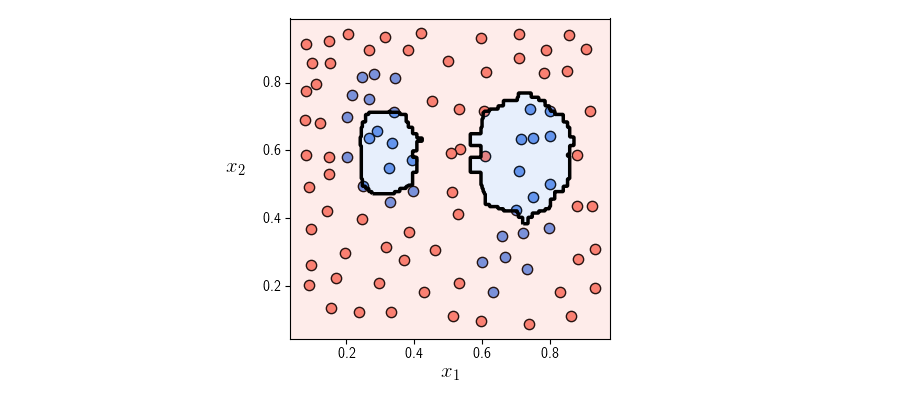

In [9]:
weight_history = run.weight_history[40:90]
aninmation_demo.animate_static_N2_simple(weight_history,run)

<IPython.core.display.Javascript object>


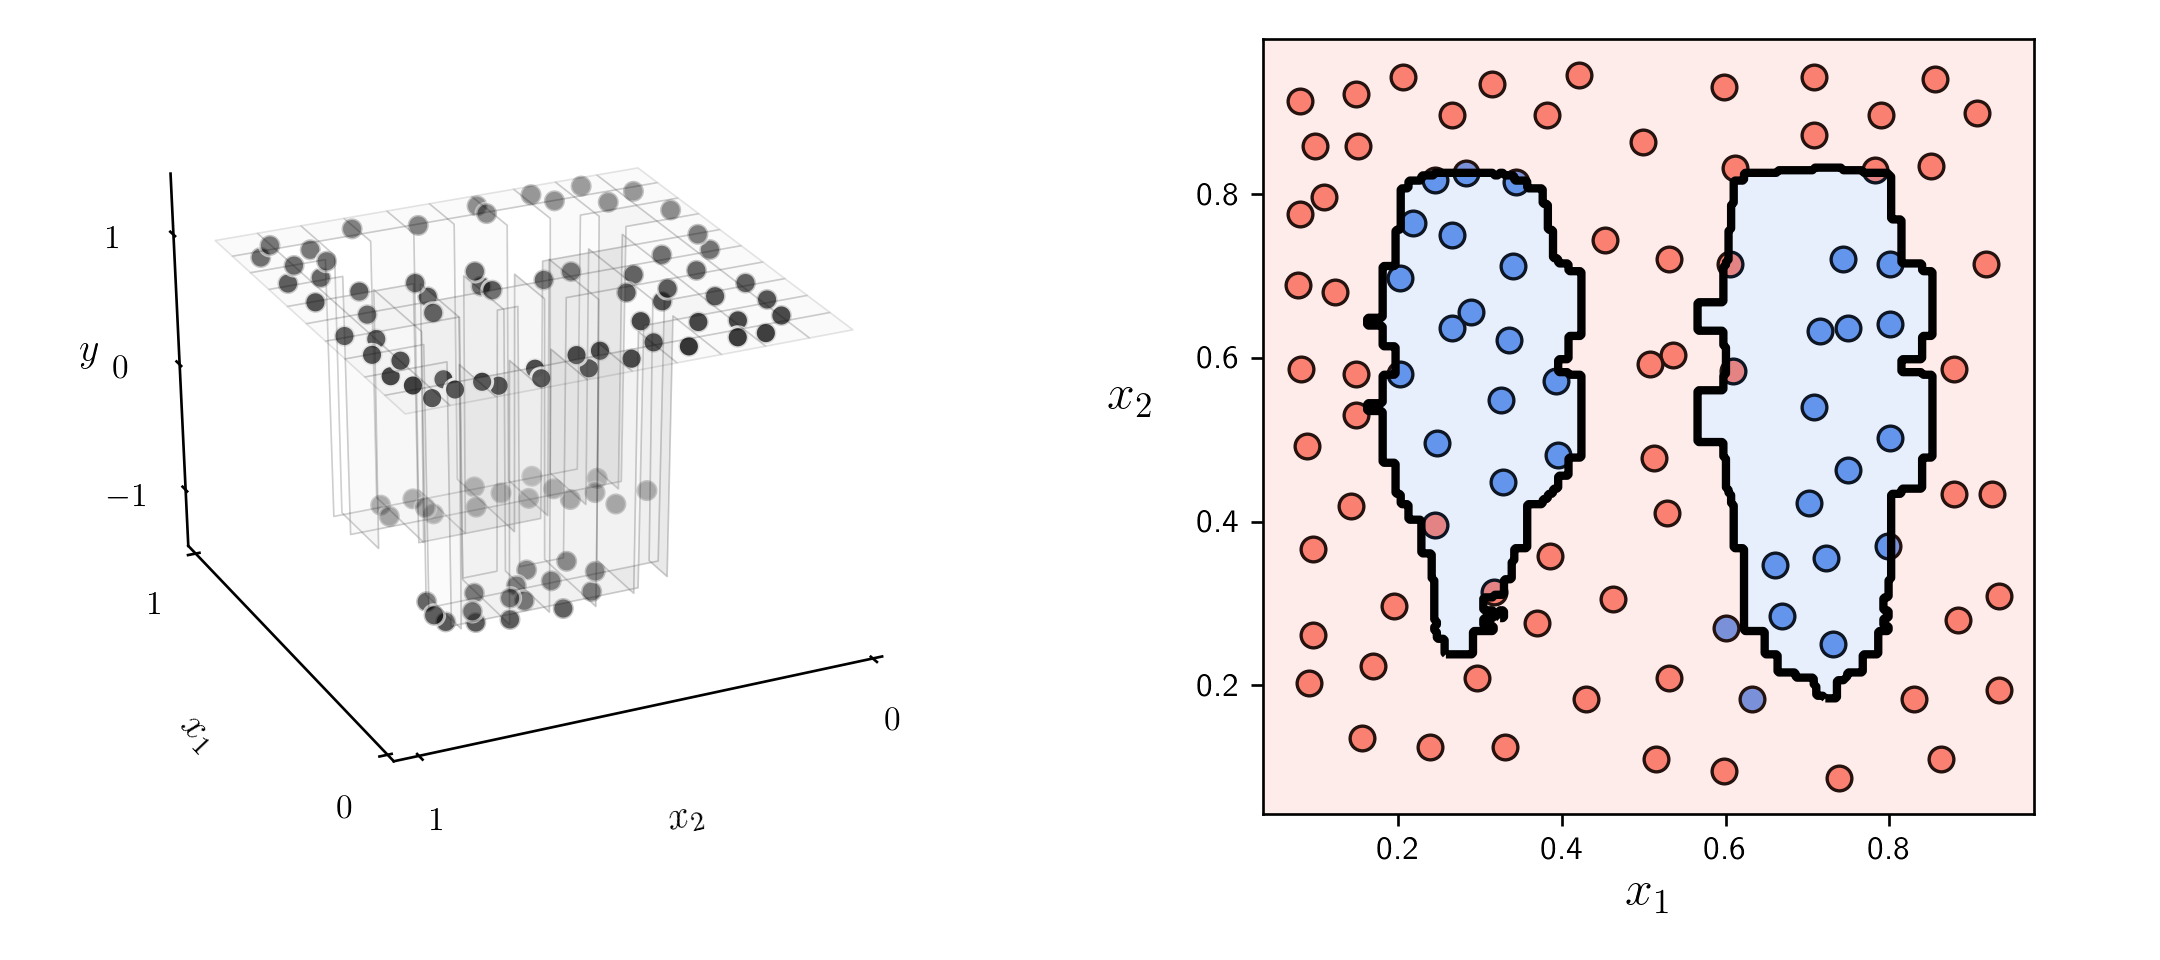

In [23]:
# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_simple(w_best,run,view = [30,155])

# multiclass classification

<IPython.core.display.Javascript object>


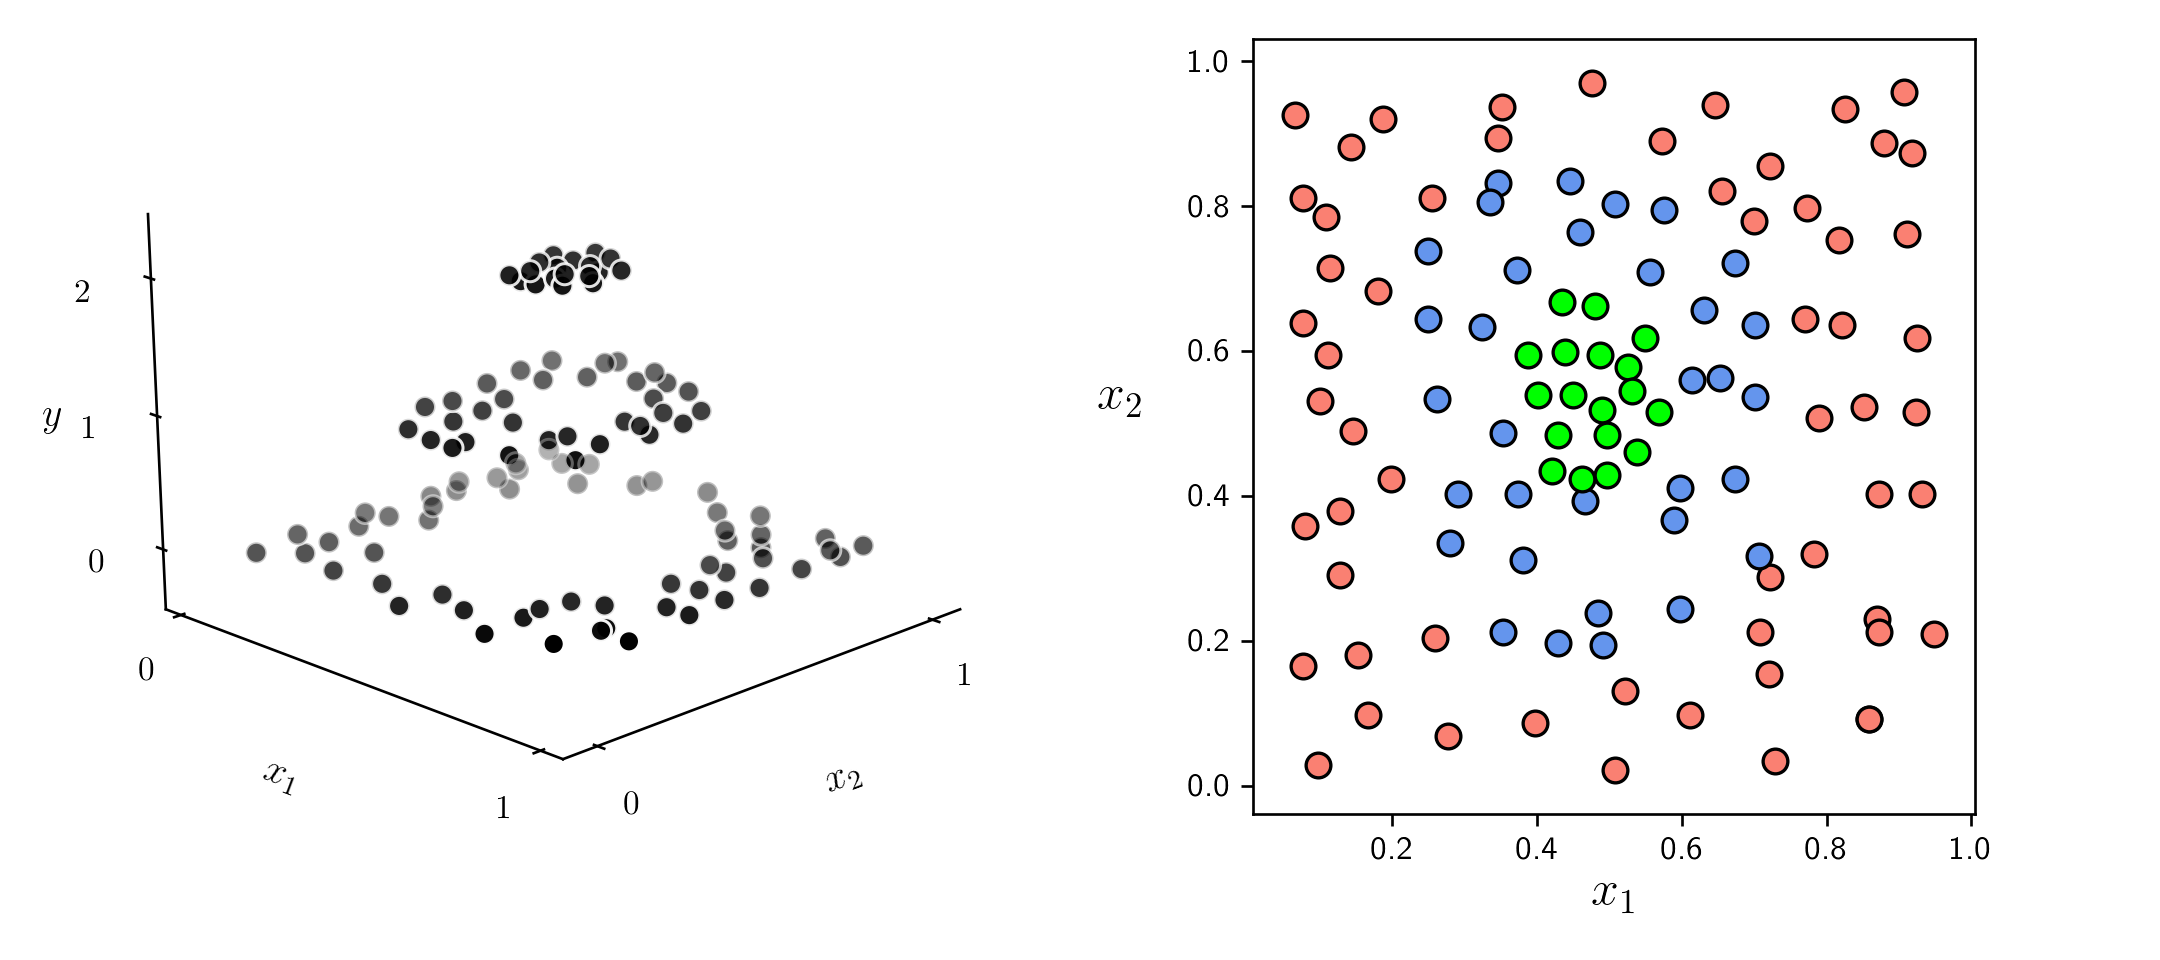

In [28]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '3_layercake_data.csv')
x = demo.x.T
y = demo.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

In [29]:
# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

In [49]:
# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,3)); max_its = 100; alpha_choice = 10**(-2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


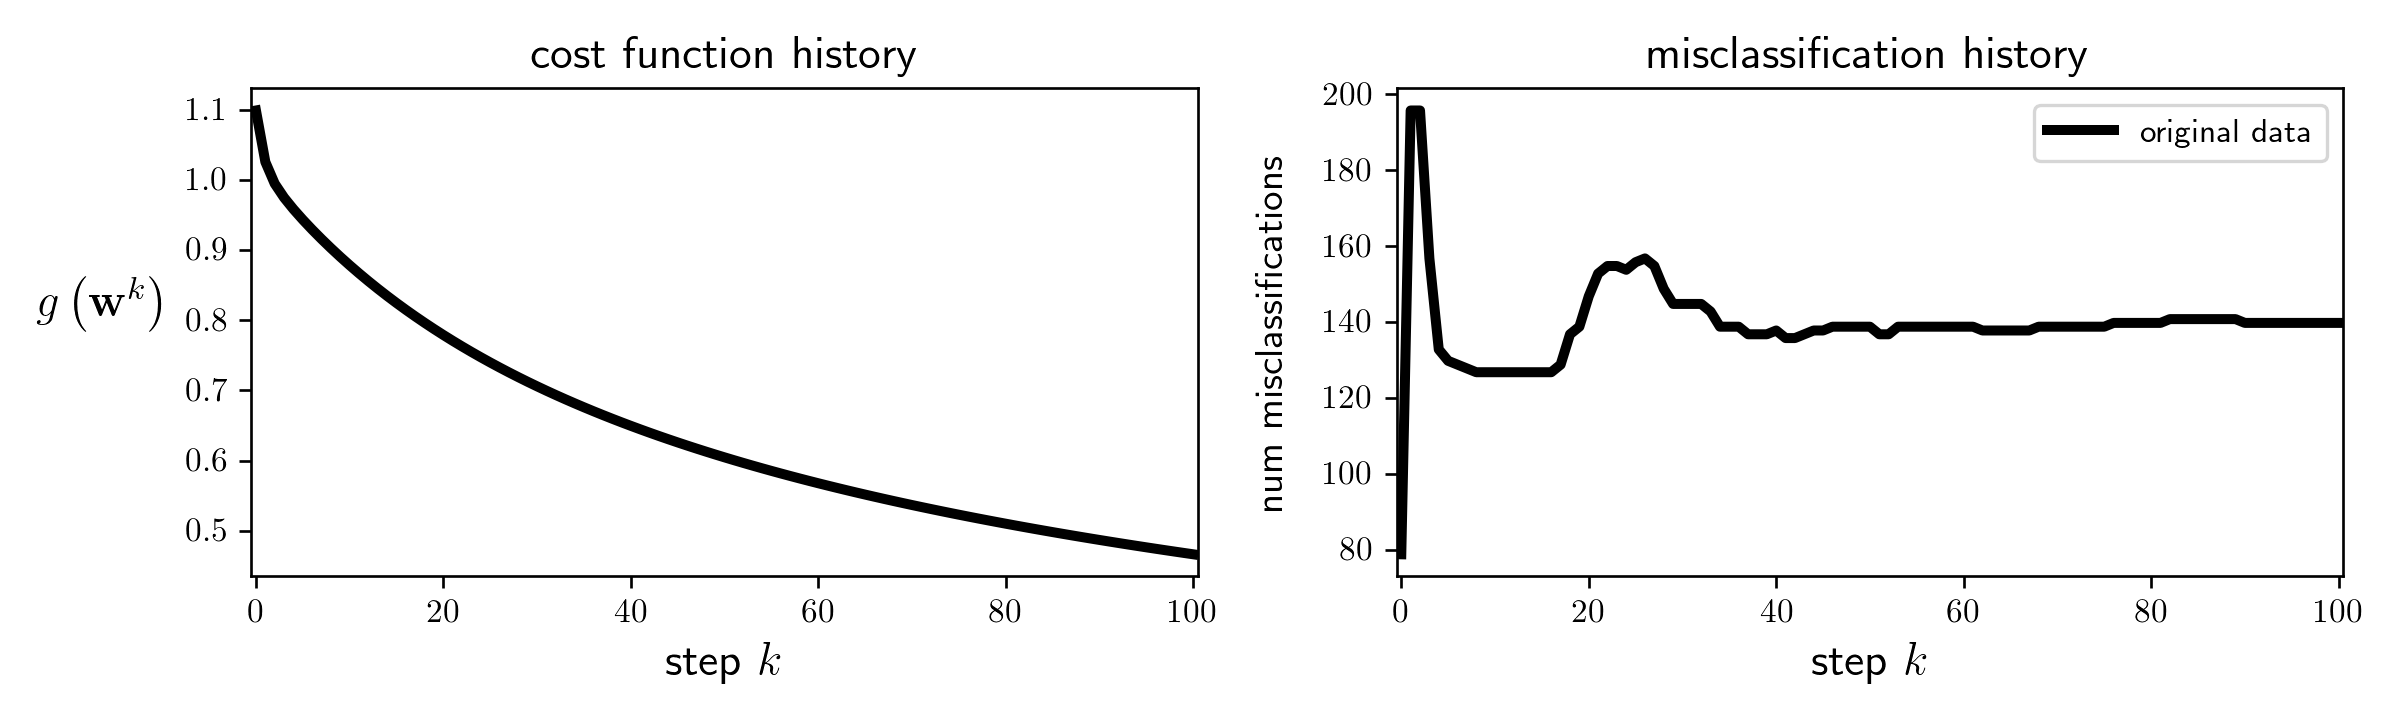

In [50]:
plotter = classif_history_plotter.Visualizer()
plotter.plot_cost_histories([run.cost_history],[count_history],start = 0,points = False,labels = ['original data'])

<IPython.core.display.Javascript object>


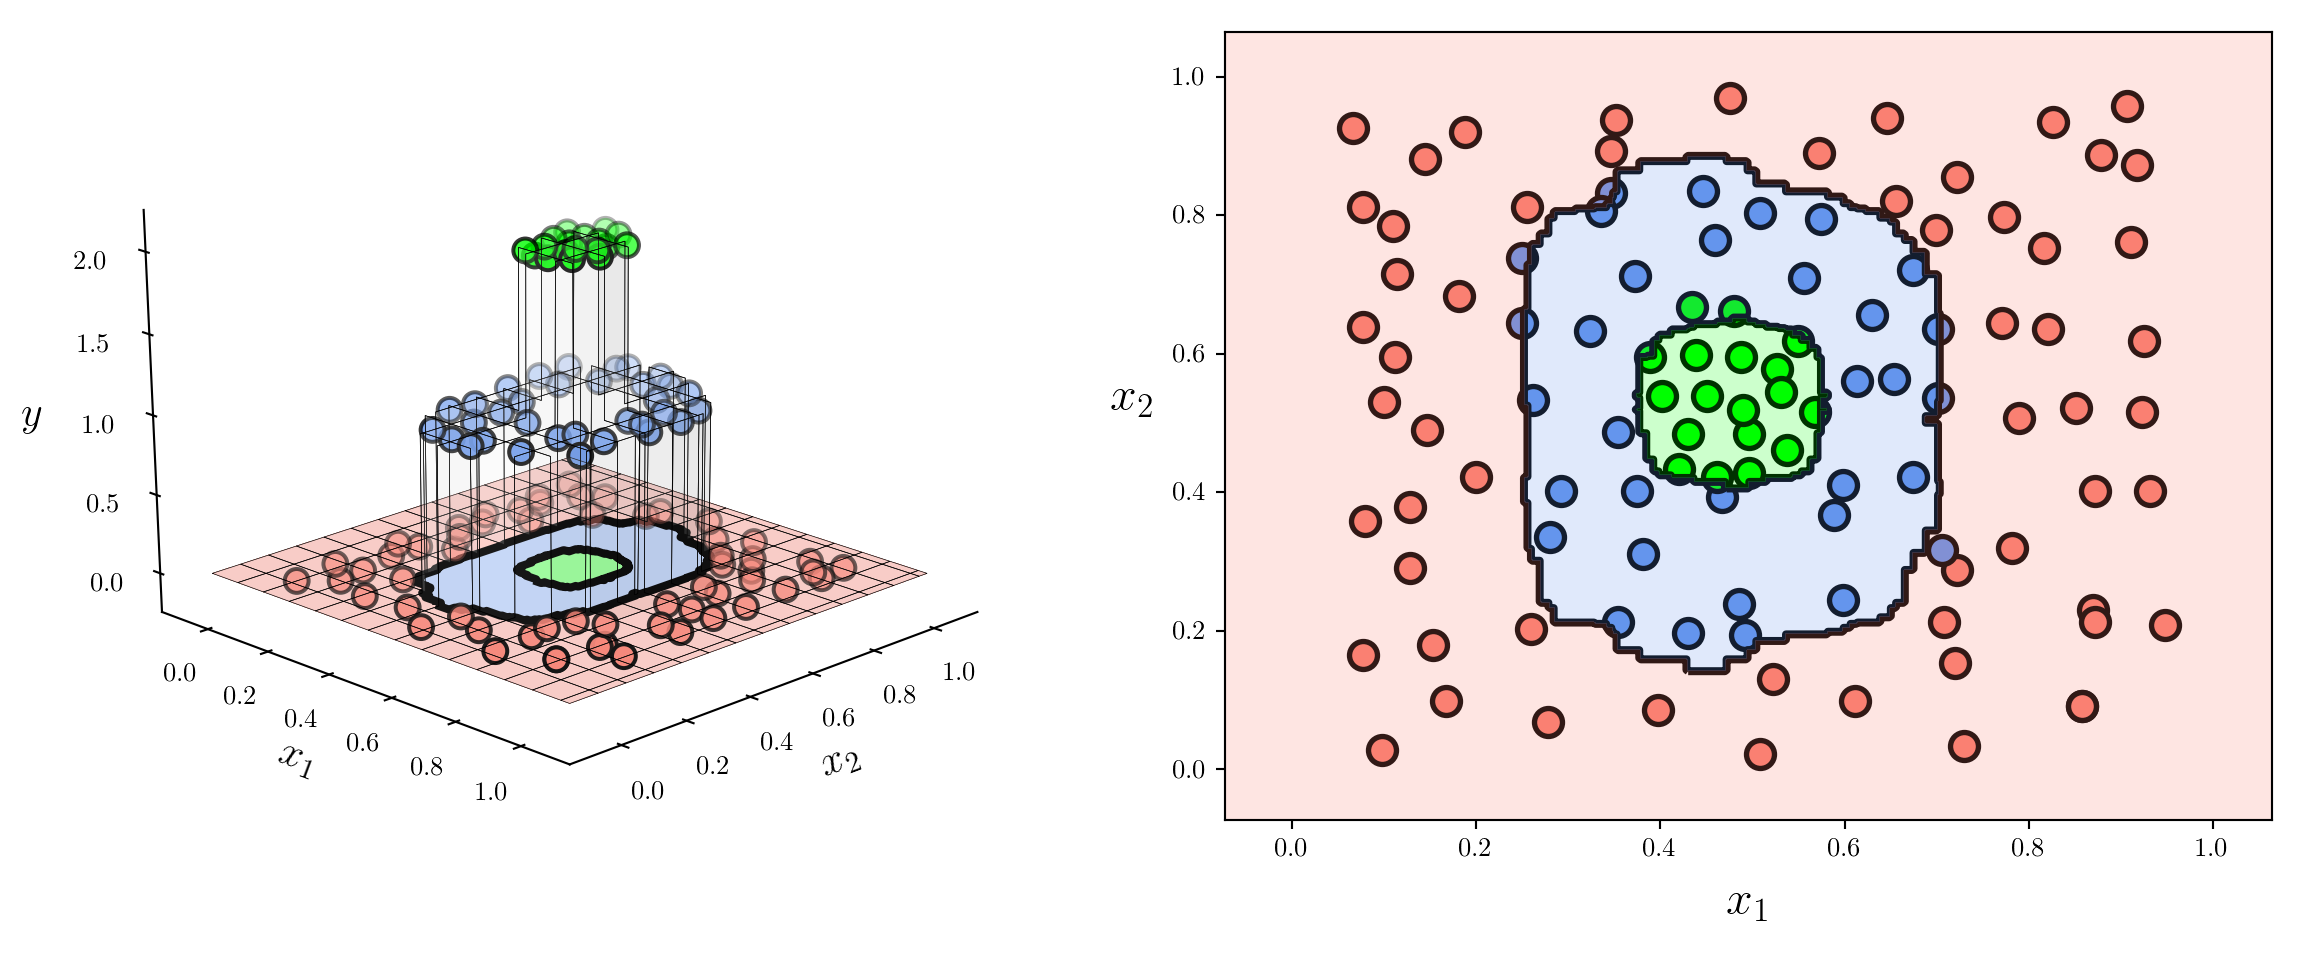

In [52]:
# plot result of nonlinear multiclass classification
w_best = run.weight_history[-1]
demo.multiclass_plot(run,w_best)

In [8]:
# create instance of linear regression demo, used below and in the next examples
csvname = datapath + 'perfect_circle_data.csv'

demo = nonlib.nonlinear_classification_visualizer.Visualizer(csvname)
x = demo.x.T
y = demo.y[np.newaxis,:]

# create splits, levels, and dims
splits,levels,dims =  create_boost_stumps(x,y)

# parameters for our two runs of gradient descent
w = np.zeros((len(splits)+1,1)); max_its = 3; alpha_choice = 10**(-2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)
count_history = [run.counting_cost(v) for v in run.weight_history]

<IPython.core.display.Javascript object>


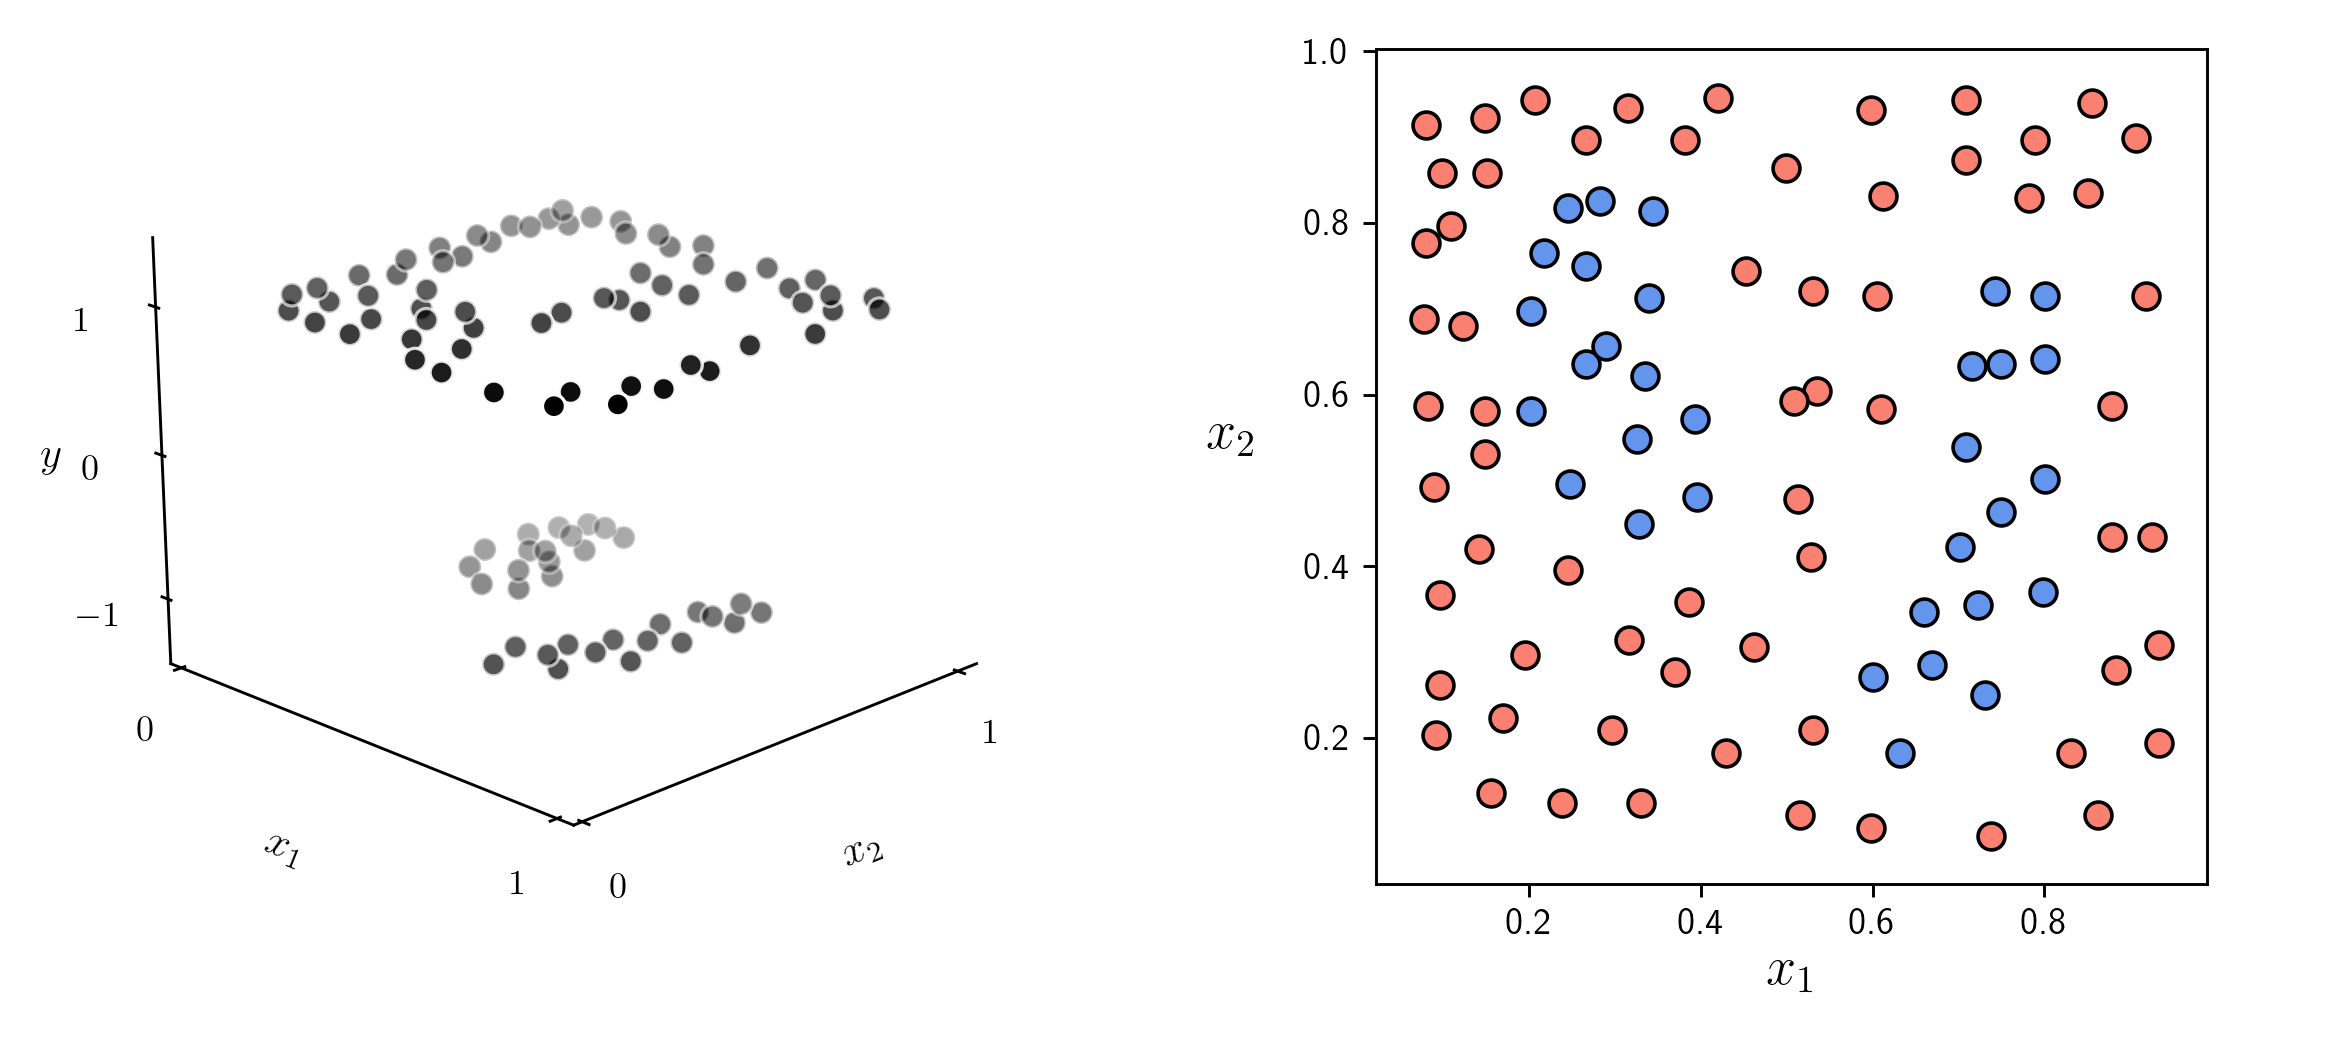

<IPython.core.display.Javascript object>


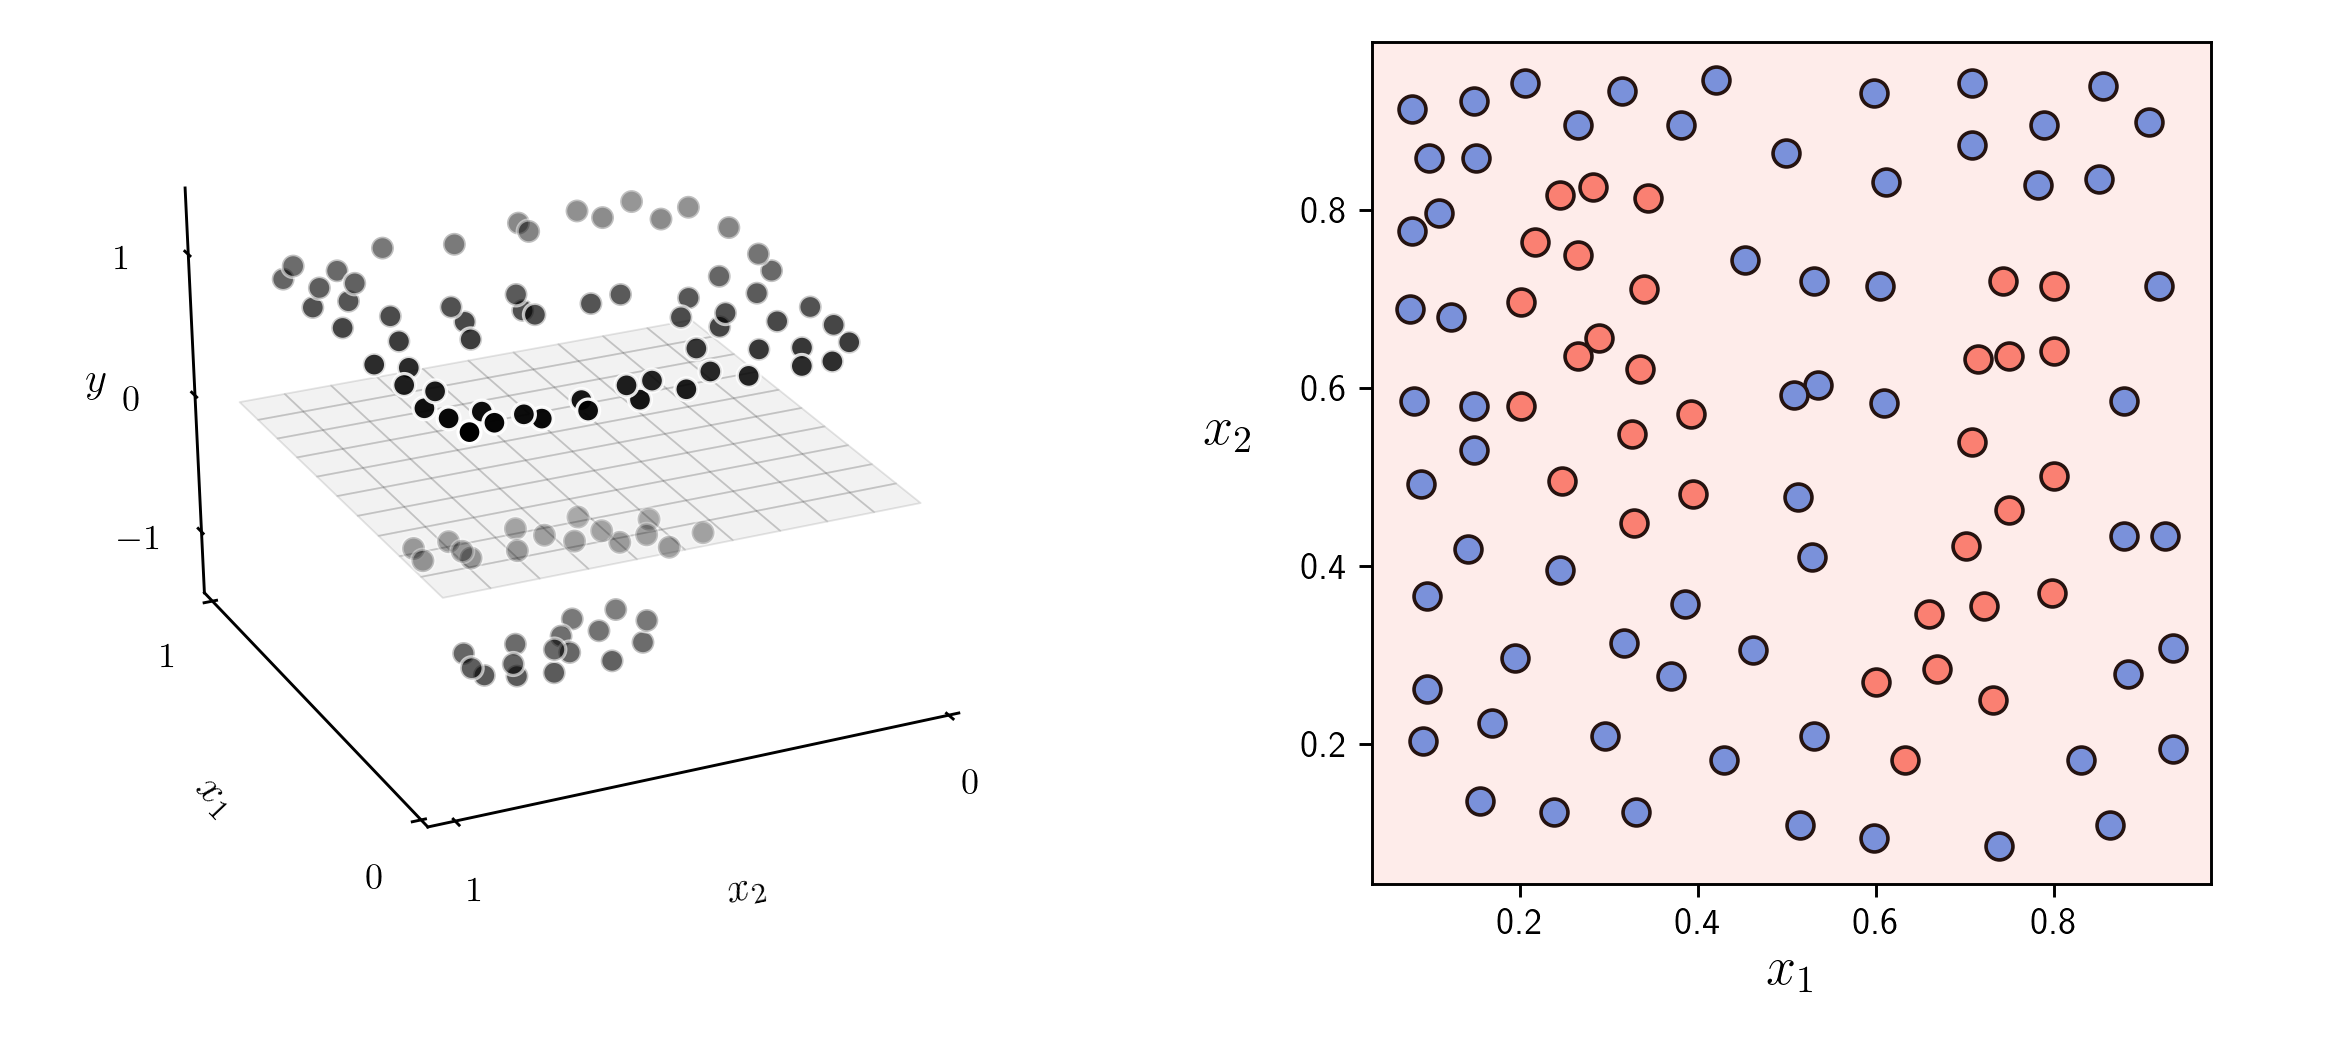

In [9]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '2eggs_data.csv')
x = demo.x.T
y = demo.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data()

# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_simple(w_best,run,view = [30,155])